# Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Nonlinear and Linearized Ops

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for **VTI anisotropic variable density visco- pseudo- acoustics** using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are two notebooks in this series:

##### 1. Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Nonlinear and Linearized Ops
- Implement the nonlinear modeling operations. 
- [ssa_11_vti_implementation.ipynb](ssa_11_vti_implementation.ipynb)

##### 2. Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [ssa_12_vti_correctness.ipynb](ssa_12_vti_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for isotropic and TTI anisotropy ([README.md](README.md)).

## Important note

This notebook and those following assume familiarity with the work shown in the first 3 notebooks. The introductory notebook In particular has information on the use of skew symmetric derivatives, our use of a dissipation only attenuation term, and motivation for implementing that attenuation term with a backward time difference. 

## Outline 
1. Define symbols and notation
1. The SSA VTI wave equation
1. The nonlinear operator
1. The Jacobian operator
1. The adjoint of the Jacobian operator
1. Derive time update equations
1. Create the Devito grid and model fields 
1. Implement, run, plot results for the nonlinear forward operator 
1. Implement, run, plot results for the Jacobian forward operator 
1. Implement, run, plot results for the Jacobian adjoint operator 
1. References

<a id="nl_symbols"></a>
## Table of symbols

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
| :---         | :---              | :--- |
| $\omega_c = 2 \pi f_c$ | center angular frequency | constant |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $f(x,y,z)$ | $V_s$ approximation defined: $f = 1 - \frac{\displaystyle V_s^2}{\displaystyle V_p^2}$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $v(x,y,z)$ | Total P wave velocity ($v_0+\delta v$) | function of space |
| $v_0(x,y,z)$ | Background P wave velocity    | function of space |
| $\delta v(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $\epsilon(x,y,z)$ | Total Thomsen's weak anisotropy $\epsilon$  | function of space |
| $\epsilon_0(x,y,z)$ | Background Thomsen's weak anisotropy $\epsilon$  | function of space |
| $\delta \epsilon(x,y,z)$ | Perturbation to Thomsen's weak anisotropy $\epsilon$  | function of space |
| $\tilde{\eta}(x,y,z)$ | Total anellipticity, defined: $\tilde{\eta} = \sqrt{\frac{\displaystyle 2\bigl(\epsilon - \delta\bigr)}{\displaystyle f + 2\ \epsilon}}$ | function of space, note: $\sqrt{1 - \tilde{\eta}^2} = \frac{\displaystyle f + 2\delta}{\displaystyle f + 2\ \epsilon}$ |
| $\tilde{\eta}(x,y,z)$ | Background anellipticity | function of space |
| $\delta \tilde{\eta}(x,y,z)$ | Perturbation to anellipticity | function of space |
| $\delta(x,y,z)$ | Thomsen's weak anisotropy $\delta$  | function of space |
| $p(t,x,y,z)$ | Total quasi-P pressure wavefield ($u_0+\delta u$)| function of time and space |
| $p_0(t,x,y,z)$ | Background quasi-P pressure wavefield | function of time and space |
| $\delta p(t,x,y,z)$ | Perturbation to quasi-P pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Total quasi-S pressure wavefield ($u_0+\delta u$)| function of time and space |
| $s_0(t,x,y,z)$ | Background quasi-S pressure wavefield | function of time and space |
| $\delta s(t,x,y,z)$ | Perturbation to quasi-S pressure wavefield | function of time and space |
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $g_1,\ g_2,\ g_3$ | Derivative operator notation for VTI and TTI operators | $\textit{see below}$ |
| $\tilde{g}_1,\ \tilde{g}_2,\ \tilde{g}_3$ | Derivative operators notation for VTI and TTI operators | $\textit{see below}$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ |  
| $q_p(t,x,y,z)$ | Quasi-P source | function of time, localized in space to source location |
| $q_s(t,x,y,z)$ | Quasi-S source | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta v$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta v \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta v$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ | 
| $\theta,\ \phi$ | azimuth and tilt angle for TTI symmetry axis definition | function of space | 

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

## Derivative operator notation for VTI and TTI operators

The VTI and TTI operators are very similar, and a small change in derivative notation allows using the same form for both these operators. We introduce now notation suitable for both VTI and TTI systems, and continue below with the implementation of the VTI form.

We use the symbols $(g_1,\ g_2,\ g_3)$ and $(\tilde{g}_1,\ \tilde{g}_2,\ \tilde{g}_3)$ to indicate the *inside* and *outside* derivatives for these operators. For VTI, these operators map one-to-one into the usual orthogonal derivative operators $(\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z})$ and $(\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z})$. For TTI these operators involve both the usual derivatives and coordinate rotations. Below the TTI axes of symmetry are defined by azimumth $\theta$ and tilt angle $\phi$, specified in radians.

$$
\begin{aligned}
&\text{Operator}&
    \quad &\text{VTI}&
        \quad &\text{TTI} \\[5pt]
&g_1\bigl(\cdot\bigr)&
    \quad &\overrightarrow{\partial_x}\bigl(\cdot\bigr)&
        \quad &+ cos \theta\ cos \phi\ \overrightarrow{\partial_x} \bigl(\cdot\bigr) 
                      + cos \theta\ sin \phi\ \overrightarrow{\partial_y} \bigl(\cdot\bigr)
                      - sin \theta\ \overrightarrow{\partial_z} \bigl(\cdot\bigr) \\[5pt]
&g_2\bigl(\cdot\bigr)&
    \quad &\overrightarrow{\partial_y}\bigl(\cdot\bigr)&
        \quad &- sin \phi\ \overrightarrow{\partial_x} \bigl(\cdot\bigr) 
                      + cos \phi\ \overrightarrow{\partial_y} \bigl(\cdot\bigr) \\[5pt]
&g_3\bigl(\cdot\bigr)&
    \quad &\overrightarrow{\partial_z}\bigl(\cdot\bigr)&
        \quad &+ sin \theta\ cos \phi\ \overrightarrow{\partial_x} \bigl(\cdot\bigr) 
                      + sin \theta\ sin \phi\ \overrightarrow{\partial_y} \bigl(\cdot\bigr)
                      + cos \theta\ \overrightarrow{\partial_z} \bigl(\cdot\bigr) \\[5pt]
&\tilde{g}_1\bigl(\cdot\bigr)&
    \quad &\overleftarrow{\partial_x}\bigl(\cdot\bigr)&
        \quad &+ \overleftarrow{\partial_x} \bigl( cos \theta\ cos \phi\ \cdot \bigr)
                      + \overleftarrow{\partial_y} \bigl( cos \theta\ sin \phi\ \cdot \bigr)
                      - \overleftarrow{\partial_z} \bigl( sin \theta\ \cdot \bigr) \\[5pt]
&\tilde{g}_2\bigl(\cdot\bigr)&
    \quad &\overleftarrow{\partial_y}\bigl(\cdot\bigr)&
        \quad &- \overleftarrow{\partial_x} \bigl( sin \phi\ \cdot \bigr) 
                      + \overleftarrow{\partial_y} \bigl( cos \phi\ \cdot \bigr) \\[5pt]
&\tilde{g}_3\bigl(\cdot\bigr)&
    \quad &\overleftarrow{\partial_z}\bigl(\cdot\bigr)&
        \quad &+ \overleftarrow{\partial_x} \bigl( sin \theta\ cos \phi\ \cdot \bigr)
                      + \overleftarrow{\partial_y} \bigl( sin \theta\ sin \phi\ \cdot \bigr)
                      + \overleftarrow{\partial_z} \bigl( cos \theta\ \cdot \bigr) \\[5pt]
\end{aligned}
$$

#### Skew symmetry of operators $(g_1,\ \tilde{g}_1)$,  $(g_2,\ \tilde{g}_2)$,  $(g_3,\ \tilde{g}_3)$ 

These pairs of operators are skew symmetric, which can be verified with random domain vectors $a$ and $b$ via the following adjoint tests:

$$
\begin{aligned}
g_1(a) \cdot b\ &\approx\ - a \cdot \tilde{g}_1(b) \\[5pt]
g_2(a) \cdot b\ &\approx\ - a \cdot \tilde{g}_2(b) \\[5pt]
g_3(a) \cdot b\ &\approx\ - a \cdot \tilde{g}_3(b) 
\end{aligned}
$$

We perform this unit test below as we did in the 1st isotropic notebook.

<a id="nl_we"></a>
## The Nonlinear Operator

Our skew self adjoint VTI anisotropic wave equation has two coupled equations for quasi-P state variable $p$ and quasi-shear state variable $s$, and is written:

$$
\begin{aligned}
\frac{b}{v^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}p + \partial_{tt}p \right) =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ \bigl(g_1\ p\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ \bigl(g_2\ p\bigr) \biggr] \\[5pt]  
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr)\ \bigl(g_3\ p\bigr) + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ s\bigr) \biggr] + q_p \\[15pt]
\frac{b}{v^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}s + \partial_{tt}s \right) =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ s\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_2\ s\bigr) \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ \bigl(g_3\ s\bigr) + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ p\bigr) \biggr] + q_s
\end{aligned}
$$

Note that we only inject pressure sources into the quasi-P equation via $q_p$, but we keep the $q_s$ term as it will help us to understand the linearized source terms for the Jacobian operators.

#### Coupling between quasi-P and quasi-S state variables

The two equations are coupled only via vertical derivatives and the terms:

$$
\begin{aligned}
&\tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ s\bigr) \right] 
    \quad \text{for quasi-P} \\[5pt]
&\tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ p\bigr) \right] 
    \quad \text{for quasi-S}
\end{aligned}
$$

This means there are *zero horizontal cross terms* between the quasi-P and quasi-S state variables $p, s$ for the VTI pseudo- acoustic system.

#### Use for nonlinear and linearized operations

As discussed in previous notebooks, this energy conserving skew self adjoint form allows using the same equations for all nonlinear and linearized operations required for quasi- Newton optimization. Some other widely utilized non energy conserving formulations (not referenced here directly) can provide unstable linearized adjoints, and thus unstable gradients for updating anisotropy parameters.  

#### Operator notation
In operator notation, where the operator is nonlinear with respect to model $m$ to the left of semicolon inside the square brackets, and linear with respect to the source $q$ to the right of semicolon inside the square brackets.

$$
F[m; q] = r
$$

For this VTI anisotropic system, the material parameter model vector $m$ is defined as:

$$
m = 
\begin{bmatrix}
v \\ \epsilon \\\tilde{\eta} 
\end{bmatrix}
$$

## The Jacobian forward operator

In this section we linearize about a background model and take the derivative of the nonlinear operator to obtain the Jacobian forward operator. 

#### Operator notation
In operator notation, where the derivative of the modeling operator is now linear in the model perturbation vector $\delta m$, the Jacobian operator maps a perturbation in the material parameter model $\delta m$ into a perturbation in the receiver wavefield $\delta r$. 

$$
\nabla F[m; q]\ \delta m = \delta r
$$

For this VTI anisotropic system, the perturbation to the material parameter model vector $\delta m$ is defined as:

$$
\delta m = 
\begin{bmatrix}
\delta v \\ \delta \epsilon \\ \delta \tilde{\eta} 
\end{bmatrix}
$$

#### 1. Begin by simplifying notation 
To simplify the treatment below we introduce the operator $L_t[\cdot]$, accounting for the time derivatives inside the parentheses on the left hand side of the wave equation. 

$$
L_t[\cdot] \equiv \frac{\omega_c}{Q} \overleftarrow{\partial_t}[\cdot] + \partial_{tt}[\cdot]
$$

Next we re-write the coupled wave equation using this notation.

$$
\begin{aligned}
\frac{b}{v^2} L_t[p] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ \bigl(g_1\ p\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ \bigl(g_2\ p\bigr) \biggr] \\[5pt]  
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr)\ \bigl(g_3\ p\bigr) + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ s\bigr) \biggr] + q_p \\[15pt]
\frac{b}{v^2} L_t[s] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ s\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_2\ s\bigr) \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ \bigl(g_3\ s\bigr) + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ p\bigr) \biggr] + q_s
\end{aligned}
$$

#### 2. Linearize
To linearize we treat material parameters as the sum of background and perturbation models, and total quasi-P and quasi-S wavefields as sums of background and perturbation wavefields.

$$
\begin{aligned}
v &= v_0 + \delta v \\[5pt]
\epsilon &= \epsilon_0 + \delta \epsilon \\[5pt]
\tilde{\eta} &= \tilde{\eta}_0 + \delta \tilde{\eta} \\[5pt]
p &= p_0 + \delta p \\[5pt]
s &= s_0 + \delta s
\end{aligned}
$$

Rewrite wave equations with these material parameter and state variable expansions:

$$
\begin{aligned}
\frac{b}{(v_0+\delta v)^2} L_t[p_0 + \delta p] =\ 
   & \tilde{g}_1 \biggl\{b\ \bigl[1 + 2\ \left(\epsilon_0 + \delta \epsilon\right) \bigr]\ 
       g_1\ (p_0 + \delta p) \biggr\}\ + \\[5pt]
   & \tilde{g}_2 \biggl\{b\ \bigl[1 + 2\ \left(\epsilon_0 + \delta \epsilon\right) \bigr]\ 
       g_2\ (p_0 + \delta p) \biggr\}\ + \\[5pt]
   & \tilde{g}_3 \biggl\{b\ \bigl[1 - f\ {\left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)}^2\bigr]\ 
       g_3\ (p_0 + \delta p) \biggr\}\ + \\[5pt]
   & \tilde{g}_3 \biggl\{b\ f\ \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)\ 
       \sqrt{1 - \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)^2}\ g_3\ (s_0 + \delta s) \biggr\} + q_p \\[15pt]
\frac{b}{(v_0+\delta v)^2} L_t[s_0 + \delta_s] =\ 
   & \tilde{g}_1 \biggl\{b\ \bigl[1 - f\bigr]\ g_1\ (s_0 + \delta s) \biggr\}\ + \\[5pt]
   & \tilde{g}_2 \biggl\{b\ \bigl[1 - f\bigr]\ g_2\ (s_0 + \delta s) \biggr\}\ + \\[5pt]
   & \tilde{g}_3 \biggl\{b\ \bigl[p1 - f + f\ \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)^2\bigr]\ 
       g_3\ (s_0 + \delta s) \biggr\}\ + \\[5pt] 
   & \tilde{g}_3 \biggl\{b\ f\ \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)\ 
       \sqrt{1 - \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)^2}\ g_3\ (p_0 + \delta p) \biggr\} \\[15pt]
\end{aligned}
$$

#### 3. Take derivative w.r.t. model parameters
Next we take the derivatives with respect to $v$, $\epsilon$, and $\tilde{\eta}$ keeping only terms up to first order in perturbations, and subtract the background model PDE equation. 

As in the isotropic case shown in the first notebook, we end up with the exact same equation as used for the nonlinear forward but with reference state variables $p, s$ replaced with perturbed state variables $\delta p, \delta s$; and with reference source terms $q_p, q_s$ replaced with the Born source terms related to the derivatives of the linearization of the material parameters. 

The use of the Jacobian operator requires first solving in the background model for the reference wavefields $p_0, s_0$ for all time samples. 

$$
\begin{aligned}
\bigl[ \texttt{Born p}\bigr] =\ & \frac{2\ b\ \delta v}{v_0^3} L_t[p_0] 
    + \tilde{g}_1 \biggl[ 2\ b\ \delta \epsilon\ \bigl(g_1\ p_0\bigr) \biggr]
    + \tilde{g}_2 \biggl[ 2\ b\ \delta \epsilon\ \bigl(g_2\ p_0\bigr) \biggr] \\[5pt]
  &\quad + \tilde{g}_3 \biggl[ 
    - 2\ b\ f\ \tilde{\eta}_0\ \delta \tilde{\eta}\ \bigl(g_3\ p_0\bigr) 
    + \frac{b\ f\ \bigl(1 - 2\ \tilde{\eta}_0^2 \bigr)}{\sqrt{1 - \tilde{\eta}_0^2} }\ \bigl(g_3\ m_0\bigr)
    \biggr]
\\[15pt]
\bigl[ \texttt{Born s}\bigr] =\ & \frac{2\ b\ \delta v}{v_0^3} L_t[s_0] \\[5pt]
  &\quad + \tilde{g}_3 \biggl[ 
    + 2\ b\ f\ \tilde{\eta}_0\ \delta \tilde{\eta}\ \bigl(g_3\ m_0\bigr)
    + \frac{b\ f\ \bigl(1 - 2\ \tilde{\eta}_0^2 \bigr)}{\sqrt{1 - \tilde{\eta}_0^2} }\ \bigl(g_3\ p_0\bigr)
    \biggr]
\end{aligned}
$$

The Jacobian forward finite difference evolution is solved forward in time in the reference material parameter model $(v_0, \epsilon_0, \tilde{\eta}_0)$ injecting the Born source terms.

$$
\begin{aligned}
\frac{b}{v_0^2} L_t[\delta p] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ \bigl(g_1\ \delta p\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ \bigl(g_2\ \delta p\bigr) \biggr] + \\[5pt] 
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}_0^2\bigr)\ \bigl(g_3\ \delta p\bigr)
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \delta s\bigr) \biggr] +
    \bigl[\texttt{Born p}\bigr] \\[15pt]
\frac{b}{v_0^2} L_t[\delta s] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ \delta s\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_2\ \delta s\bigr) \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}_0^2\bigr)\ \bigl(g_3\ \delta s\bigr)
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \delta p\bigr) \biggr] +
    \bigl[\texttt{Born s}\bigr]
\end{aligned}
$$

## The Jacobian adjoint operator

In this section we introduce the adjoint of the Jacobian operator we derived above. The Jacobian adjoint operator maps a perturbation in receiver wavefield $\delta r$ into a perturbation in velocity model $\delta m$. In operator notation:

$$
\bigl( \nabla F[m; q] \bigr)^\top\ \delta r = \delta m
$$

#### 1. Solve the time reversed wave equation with the receiver perturbation as source
The PDE for the adjoint of the Jacobian is solved for the perturbation to the pressure wavefields $\widetilde{\delta p}, \widetilde{\delta s}$ by using the same wave equation as the nonlinear forward and the Jacobian forward, with the time reversed receiver wavefield perturbation $\widetilde{\delta r}$ injected as source. 

We use $\widetilde{\delta p}, \widetilde{\delta s}$ and $\widetilde{\delta r}$ to indicate that we solve this finite difference evolution time reversed in the reference material parameter model $(v_0, \epsilon_0, \tilde{\eta}_0)$. 

The receiver perturbation wavefield $\widetilde{\delta r}$ is only injected into the quasi-P equation, this is consistent with the nonlinear forward.

$$
\begin{aligned}
\frac{b}{v_0^2} L_t[\widetilde{\delta p}] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ \bigl(g_1\ \widetilde{\delta p}\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ \bigl(g_2\ \widetilde{\delta p}\bigr) \biggr] + \\[5pt] 
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}_0^2\bigr)\ \bigl(g_3\ \widetilde{\delta p}\bigr)
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \widetilde{\delta s}\bigr) \biggr] +
    \widetilde{\delta r} \\[15pt]
\frac{b}{v_0^2} L_t[\widetilde{\delta s}] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ \widetilde{\delta s}\bigr) \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_2\ \widetilde{\delta s}\bigr) \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}_0^2\bigr)\ \bigl(g_3\ \widetilde{\delta s}\bigr)
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \widetilde{\delta p}\bigr) \biggr]
\end{aligned}
$$

#### 2. Compute zero lag correlation  

We compute the perturbations to material parameters by zero lag correlation of the wavefield perturbations $\widetilde{\delta p}, \widetilde{\delta s}$ solved in step 1 with the following expressions. We omit the dimensionality $(t,x,y,z)$ on wavefields for brevity.

You will also notice that the zero lag correlations below is the first time you have seen the forward derivative operators $(g_1, g_2, g_3)$ without adjacent adjoint derivatives $(\tilde{g}_1, \tilde{g}_2, \tilde{g}_3)$. This is due to the integration by parts required for the adjoint state solution, and maps for example $\tilde{g}_1 \rightarrow g_1$.

$$
\begin{aligned}
\delta v(x,y,z) = &+ \frac{\displaystyle 2\ b}{\displaystyle v_0^3}\ \sum_t 
    \biggl\{ 
        \widetilde{\delta p}\ L_t[p_0] + \widetilde{\delta s}\ L_t[s_0]
    \biggr\}\\[20pt]
\delta \epsilon(x,y,z) = &- 2\ b\ \sum_t 
    \biggl\{ 
        \bigl( g_1\ p_0 \bigr)\ \bigl( g_1\ \widetilde{\delta p} \bigr)
        + \bigl( g_2\ p_0 \bigr)\ \bigl( g_2\ \widetilde{\delta p} \bigr)
    \biggr\}\\[20pt]
\delta \tilde{\eta}(x,y,z) = 
&+ b\ \sum_t \biggl\{ 
    \biggl[ 2\ f\ \tilde{\eta}_0\ \bigl(g_3\ p_0\bigr) - 
        \frac{f\left(1 - 2\ \tilde{\eta}_0^2\right)}{\sqrt{1 - \tilde{\eta}_0^2}} \bigl(g_3\ s_0\bigr) \biggr]\ 
            \bigl( g_3\ \widetilde{\delta p} \bigr)
    \biggr\}\\[5pt]
&- b\ \sum_t \biggl\{ 
    \biggl[ 2\ f\ \tilde{\eta}_0\ \bigl(g_3\ s_0\bigr) +
        \frac{f\left(1 - 2\ \tilde{\eta}_0^2\right)}{\sqrt{1 - \tilde{\eta}_0^2}} \bigl(g_3\ p_0\bigr) \biggr]\ 
            \bigl( g_3\ \widetilde{\delta s} \bigr)
    \biggr\}
\end{aligned}
$$

## Solve for the time update equations

We next solve for the time update equations, in the same way as in the initial isotropic notebooks. 

We demonstrate for the nonlinear equation with state variables $(p, s)$, but the same machinery works for the linearized Jacobian forward with state variables $(\delta p, \delta s)$ and the linearized Jacobian adjoint with state variables $(\widetilde{\delta p}, \widetilde{\delta s})$.

#### 1. Temporal numerical derivatives, sorted into useful form
$$
\begin{aligned}
\overleftarrow{\partial_{t}}\ u &= \frac{\displaystyle u(t) - \
    u(t-\Delta_t)}{\displaystyle \Delta_t}\\[10pt]
u(t+\Delta_t)\ &= \Delta_t^2\ \partial_{tt}u + 2\ u(t) - u(t-\Delta_t)
\end{aligned}
$$

Above we use $u$ as a placeholder for both $p$ and $s$.

#### 2. Solve the quasi-P and quasi-S wave equations for $\partial_{tt}p$ and $\partial_{tt}s$ 

$$
\begin{aligned}
\partial_{tt}p = \frac{v^2}{b}\ \biggl\{
   & \tilde{g}_1 \left[b\ \bigl(1 + 2\ \epsilon\bigr)\ \bigl(g_1\ p\bigr) \right] +
     \tilde{g}_2 \left[b\ \bigl(1 + 2\ \epsilon\bigr)\ \bigl(g_2\ p\bigr) \right] + \\[5pt]
   & \tilde{g}_3 \left[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr) \bigl(g_3\ p\bigr) +
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ s\bigr) \right] + q_p
\biggr\}\ - \frac{\omega_c}{Q} \overleftarrow{\partial_t}p \\[15pt]
\partial_{tt}s = \frac{v^2}{b}\ \biggl\{
   & \tilde{g}_1 \left[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ s\bigr) \right] +
     \tilde{g}_2 \left[b\ \bigl(1 - f\bigr)\ \bigl(g_2\ s\bigr) \right] + \\[5pt]
   & \tilde{g}_3 \left[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ \bigl(g_3\ s\bigr) +
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ p\bigr) \right] + q_s
\biggr\}\ - \frac{\omega_c}{Q} \overleftarrow{\partial_t}s
\end{aligned}
$$
 
**Note**: we now abbreviate the space parts of the wave equations (between the curly braces in the two equations above) in order to reduce repetition of long expressions.

#### 3. Plug $\overleftarrow{\partial_t} p, \overleftarrow{\partial_t} s, \partial_{tt}p, \partial_{tt}s$ from W.E. into the time update equations

$$
\begin{aligned}
p(t+\Delta_t) =\  
    & \frac{\Delta_t^2\ v^2}{b} \bigl[ \texttt{Space p} \bigr]
        - \Delta_t^2 \frac{\omega_c}{Q} \biggl( \frac{\displaystyle p(t) - p(t-\Delta_t)}
            {\displaystyle \Delta_t}\biggr) + 2\ p(t) - p(t-\Delta_t)\\[10pt]
 =\ & \frac{\Delta_t^2\ v^2}{b} \bigl[ \texttt{Space p} \bigr] 
        + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ p(t) 
        + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ p(t-\Delta_t)\\[20pt]
p(t+\Delta_t) =\  
    & \frac{\Delta_t^2\ v^2}{b} \bigl[ \texttt{Space s} \bigr]
        - \Delta_t^2 \frac{\omega_c}{Q} \biggl( \frac{\displaystyle s(t) - s(t-\Delta_t)}
            {\displaystyle \Delta_t}\biggr) + 2\ s(t) - s(t-\Delta_t)\\[10pt]
 =\ & \frac{\Delta_t^2\ v^2}{b} \bigl[ \texttt{Space s} \bigr] 
        + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ s(t) 
        + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ s(t-\Delta_t)
\end{aligned}
$$


## Imports 

We have grouped all imports used in this notebook here for consistency.

In [142]:
import numpy as np
from sympy import sqrt
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import setup_w_over_q

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# We define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'
# configuration['log-level'] = 'INFO'

## Define the VTI derivative operators $(g_1,\ g_2,\ g_3,\ \tilde{g}_1,\ \tilde{g}_2,\ \tilde{g}_3)$

Recall from above that for VTI anisotropy, these operators map to the usual orthogonal derivatives.

$$
\begin{matrix}
g_1(\cdot)\ \rightarrow\ \overrightarrow{\partial_x}(\cdot) \quad&\quad
\tilde{g}_1(\cdot)\ \rightarrow\ \overleftarrow{\partial_x}(\cdot) \\
g_2(\cdot)\ \rightarrow\ \overrightarrow{\partial_y}(\cdot) \quad&\quad
\tilde{g}_2(\cdot)\ \rightarrow\ \overleftarrow{\partial_y}(\cdot) \\
g_3(\cdot)\ \rightarrow\ \overrightarrow{\partial_z}(\cdot) \quad&\quad
\tilde{g}_3(\cdot)\ \rightarrow\ \overleftarrow{\partial_z}(\cdot) \\
\end{matrix}
$$

In [143]:
def g1(field):
    return field.dx(x0=x+x.spacing/2)

def g2(field):
    return field.dy(x0=y+y.spacing/2)

def g3(field):
    return field.dz(x0=z+z.spacing/2)

def g1_tilde(field):
    return field.dx(x0=x-x.spacing/2)

def g2_tilde(field):
    return field.dy(x0=y-y.spacing/2)

def g3_tilde(field):
    return field.dz(x0=z-z.spacing/2)

#### Unit tests demonstrating skew symmetry of operators $(g_1,\ \tilde{g}_1)$,  $(g_2,\ \tilde{g}_2)$,  $(g_3,\ \tilde{g}_3)$ 

These unit tests will be slightly different from the 1D tests in the isotropic notebook because these operators are 3D, and we test on a 3D ```Function```.

We intialize random domain vectors $(a, b)$ and implement the following equations with a Devito ```Operator```:

$$
\begin{aligned}
b_1 = g_1(a)\ , a_1 = \tilde{g}_1(b) \qquad
b_2 = g_2(a)\ , a_2 = \tilde{g}_2(b) \qquad
b_3 = g_3(a)\ , a_3 = \tilde{g}_3(b) 
\end{aligned}
$$

We then verify the dot products are equivalent:  

$$
\begin{aligned}
b_1 \cdot b \approx - a \cdot a_1 \qquad
b_2 \cdot b \approx - a \cdot a_2 \qquad
b_3 \cdot b \approx - a \cdot a_3
\end{aligned}
$$

We use the following tests for relative error (note the flipped signs in numerator and denominator due to anti- symmetry):

$$
\begin{aligned}
\frac{\displaystyle b_1 \cdot b + a \cdot a_1}
     {\displaystyle b_1 \cdot b - a \cdot a_1} < \epsilon \qquad
\frac{\displaystyle b_2 \cdot b + a \cdot a_2}
     {\displaystyle b_2 \cdot b - a \cdot a_2} < \epsilon \qquad
\frac{\displaystyle b_3 \cdot b + a \cdot a_3}
     {\displaystyle b_3 \cdot b - a \cdot a_3} < \epsilon \qquad
\end{aligned}
$$


In [144]:
#NBVAL_INGNORE_OUTPUT

# Make 3D grid to test derivatives 
n = 101
d = 1.0
shape = (n, n, n)
spacing = tuple([1 / (s-1) for s in shape])
origin = tuple([0.0 for s in shape])
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])
dtype = np.float64

# Initialize Devito grid and Functions
grid_tmp = Grid(shape=shape, extent=extent, origin=origin, dtype=dtype)
x,y,z = grid_tmp.dimensions

a = Function(name='a', grid=grid_tmp, space_order=8)
a1 = Function(name='a1', grid=grid_tmp, space_order=8)
a2 = Function(name='a2', grid=grid_tmp, space_order=8)
a3 = Function(name='a3', grid=grid_tmp, space_order=8)

b = Function(name='b', grid=grid_tmp, space_order=8)
b1 = Function(name='b1', grid=grid_tmp, space_order=8)
b2 = Function(name='b2', grid=grid_tmp, space_order=8)
b3 = Function(name='b3', grid=grid_tmp, space_order=8)

# Fill f1 and g1 with random values in [-1,+1]
a.data[:] = -1 + 2 * np.random.rand(n,)
b.data[:] = -1 + 2 * np.random.rand(n,)

# Equations
eq_g1_forward = Eq(b1, g1(a))
eq_g2_forward = Eq(b2, g2(a))
eq_g3_forward = Eq(b3, g3(a))
eq_g1_adjoint = Eq(a1, g1_tilde(b))
eq_g2_adjoint = Eq(a2, g2_tilde(b))
eq_g3_adjoint = Eq(a3, g3_tilde(b))

# Define an Operator to implement these equations and execute
op = Operator([eq_g1_forward, eq_g2_forward, eq_g3_forward, 
               eq_g1_adjoint, eq_g2_adjoint, eq_g3_adjoint])
op()

# Compute the dot products and the relative error
b1b = np.dot(b1.data.flatten(), b.data.flatten())
b2b = np.dot(b2.data.flatten(), b.data.flatten())
b3b = np.dot(b3.data.flatten(), b.data.flatten())
a1a = np.dot(a1.data.flatten(), a.data.flatten())
a2a = np.dot(a2.data.flatten(), a.data.flatten())
a3a = np.dot(a3.data.flatten(), a.data.flatten())

d1 = np.abs((b1b+a1a)/(b1b-a1a))
d2 = np.abs((b2b+a2a)/(b2b-a2a))
d3 = np.abs((b3b+a3a)/(b3b-a3a))

tol = 100 * np.finfo(dtype).eps
print("b1b, a1a, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (b1b, a1a, d1, tol))
print("b2b, a2a, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (b2b, a2a, d2, tol))
print("b3b, a3a, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (b3b, a3a, d3, tol))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert d1 < 100 * np.finfo(dtype).eps
assert d2 < 100 * np.finfo(dtype).eps
assert d3 < 100 * np.finfo(dtype).eps

Allocating memory for a(117, 117, 117)
Allocating memory for b(117, 117, 117)
Operator `Kernel` generated in 0.53 s
  * lowering.Expressions: 0.35 s (66.4 %)
Flops reduction after symbolic optimization: [186 --> 75]
Allocating memory for a1(117, 117, 117)
Allocating memory for a2(117, 117, 117)
Allocating memory for a3(117, 117, 117)
Allocating memory for b1(117, 117, 117)
Allocating memory for b2(117, 117, 117)
Allocating memory for b3(117, 117, 117)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/f3fac15b196d9095c0e6b41ba8cced1e7835ba11.c` in 0.10 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0<101,101,101> with OI=1.12 computed in 0.01 s [10.80 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


b1b, a1a, diff, tol; -4.202102e+04 +4.202102e+04 +1.904655e-15 +2.220446e-14
b2b, a2a, diff, tol; -4.202102e+04 +4.202102e+04 +0.000000e+00 +2.220446e-14
b3b, a3a, diff, tol; -5.545670e+06 +5.545670e+06 +5.877792e-15 +2.220446e-14


## Instantiate the Devito grid for a two dimensional problem

We define the grid the same as the notebook implementating the isotropic nonlinear forward.

Define the dimensions and coordinates for the model. The computational domain of the model is surrounded by an *absorbing boundary region* where we implement boundary conditions to eliminate outgoing waves. We define the sizes for the interior of the model ```nx``` and ```nz```, the width of the absorbing boundary region ```npad```, and the sizes for the entire model padded with absorbing boundaries become ```nxpad = nx + 2*npad``` and ```nzpad = nz + 2*npad```.

In [145]:
# Define dimensions for the interior of the model
nx,nz = 501,501
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = tuple([0.0 for s in shape])
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])
dtype = np.float32

# Define dimensions for the model padded with absorbing boundaries
npad = 100         # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx + 2 * npad, nz + 2 * npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# If you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (501, 501)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (5000.0, 5000.0)

shape_pad;        [701 701]
origin_pad;       (-1000.0, -1000.0)
extent_pad;       (7000.0, 7000.0)

grid.shape;       (701, 701)
grid.extent;      (7000.0, 7000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define model parameters

We create ```Functions``` to represent buoyancy, velocity, and Thomsen's ansisotropy parameters $\epsilon$ and $\delta$.

Recall that our SSA wave equation is parameterized in term of $(v, \epsilon, \tilde{\eta}, f)$ and so we define $\tilde{\eta}$ in terms of $\epsilon, \delta, f$.

$$
\tilde{\eta} = \sqrt{\frac{\displaystyle 2\bigl(\epsilon - \delta\bigr)}{\displaystyle f + 2\ \epsilon}}
$$

We also instantiate the $\omega_c / Q$ attenuation model ```wOverQ```.

#### Model characteristics

Anisotropy in the source region can introduce artifacts, and so we define the model as constant velocity but isotropic over anisotropic layered model. \

We define the perturbations to the material parameters as boxes offset from the source.

In [146]:
# We create buoyancy, and both background and perturbation variables for 
# each model parameter (velocity, epsilon, eta).
space_order = 8

b    = Function(name='b', grid=grid, space_order=space_order)
vel0 = Function(name='vel0', grid=grid, space_order=space_order)
eps0 = Function(name='eps0', grid=grid, space_order=space_order)
eta0 = Function(name='eta0', grid=grid, space_order=space_order)
dvel = Function(name='dvel', grid=grid, space_order=space_order)
deps = Function(name='deps', grid=grid, space_order=space_order)
deta = Function(name='deta', grid=grid, space_order=space_order)

f    = 0.85
_vel = 1.5
_eps_top = 0.0
_del_top = 0.0
_eta_top = 0.0
_eps_bot = 0.2
_del_bot = 0.1
_eta_bot = np.sqrt(2 * (_eps_bot - _del_bot) / (f + 2 * _eps_bot)) 

# Background models are constant
b.data[:,:] = 1.0 / 1.0
vel0.data[:,:] = _vel
eps0.data[:,0*nzpad//2:1*nzpad//2] = _eps_top
eps0.data[:,1*nzpad//2:2*nzpad//2] = _eps_bot
eta0.data[:,0*nzpad//2:1*nzpad//2] = _eta_top
eta0.data[:,1*nzpad//2:2*nzpad//2] = _eta_bot

# Perturbation to velocity
size = 20
x0 = nxpad//2
z0 = nzpad//4 + 1*nzpad//16
dvel.data[:] = 0.0
dvel.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Shift perturbation to epsilon up in Z
x0 = nxpad//2
z0 = nzpad//4 + 2*nzpad//16
deps.data[:] = 0.0
deps.data[x0-size:x0+size, z0-size:z0+size] = 0.01

# Shift perturbation to epsilon down in Z
x0 = nxpad//2
z0 = nzpad//4 + 3*nzpad//16
deta.data[:] = 0.0
deta.data[x0-size:x0+size, z0-size:z0+size] = 0.02

# Initialize the attenuation profile for Q=100 model
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 1000.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

Allocating memory for b(717, 717)
Allocating memory for vel0(717, 717)
Allocating memory for eps0(717, 717)
Allocating memory for eta0(717, 717)
Allocating memory for dvel(717, 717)
Allocating memory for deps(717, 717)
Allocating memory for deta(717, 717)
Operator `WOverQ_Operator` generated in 0.18 s
  * lowering.IET: 0.08 s (46.5 %)
     * specializing.IET: 0.06 s (34.9 %)
  * lowering.Expressions: 0.06 s (34.9 %)
  * lowering.Clusters: 0.04 s (23.3 %)
Flops reduction after symbolic optimization: [19 --> 19]
Allocating memory for wOverQ(717, 717)
Operator `WOverQ_Operator` fetched `/tmp/devito-jitcache-uid5138/77228e467134cb0f4a073ac5c4f125b50e511779.c` in 0.06 s from jit-cache
Operator `WOverQ_Operator` run in 0.01 s
* section0<<701,701>,<100,701>,<100,701>,<701,100>,<701,100>,<701,701>> with OI=0.01 computed in 0.01 s [0.29 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


## Define the simulation time range and the acquisition geometry 

#### Simulation time range: 

In this notebook we run 3 seconds of simulation using the sample rate related to the CFL condition as implemented in ```examples/seismic/skew_self_adjoint/utils.py```. 

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

#### Acquisition geometry: 

**source**:
- X coordinate: left sode of model
- Z coordinate: middle of model
- We use a 10 Hz center frequency [RickerSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L280) wavelet source as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: right side of model
- Z coordinate: vertical line in model
- We use a vertical line of [Receivers](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80) as defined with a ```PointSource``` in ```examples/seismic/source.py```

In [147]:
t0 = 0.0     # Simulation time start
tn = 2500.0  # Simulation time end (1 second = 1000 msec)
dt = 1.0
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

# Source at 1/4 X, 1/4 Z, Ricker with 10 Hz center frequency
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[0,0] = origin_pad[0] + dx * nxpad//4
src.coordinates.data[0,1] = origin_pad[1] + dz * nzpad//4

# Receivers at 3/4 X, line in Z
rec = Receiver(name='rec', grid=grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:,0] = origin_pad[0] + dx * 3 * nxpad//4
rec.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,0]), np.max(rec.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,1]), np.max(rec.coordinates.data[:,1])))

Allocating memory for src(2501, 1)


Time min, max, dt, num;   0.000000 2500.000000   1.000000 2501
time_range;  TimeAxis: start=0, stop=2500, step=1, num=2501


Allocating memory for src_coords(1, 2)
Allocating memory for rec_coords(501, 2)


src_coordinate  X;            +752.0000
src_coordinate  Z;            +752.0000
rec_coordinates X min/max;   +4257.0000   +4257.0000
rec_coordinates Z min/max;      +0.0000   +5000.0000


## Plot the model 

We plot the following ```Functions```:
- Background Velocity, velocity perturbation
- Background epsilon, epsilon perturbation
- Background delta, delta perturbation
- Background Density, Q Model

Each subplot also shows:
- The location of the absorbing boundary as a dotted line
- The source location as a red star
- The line of receivers as a black vertical line

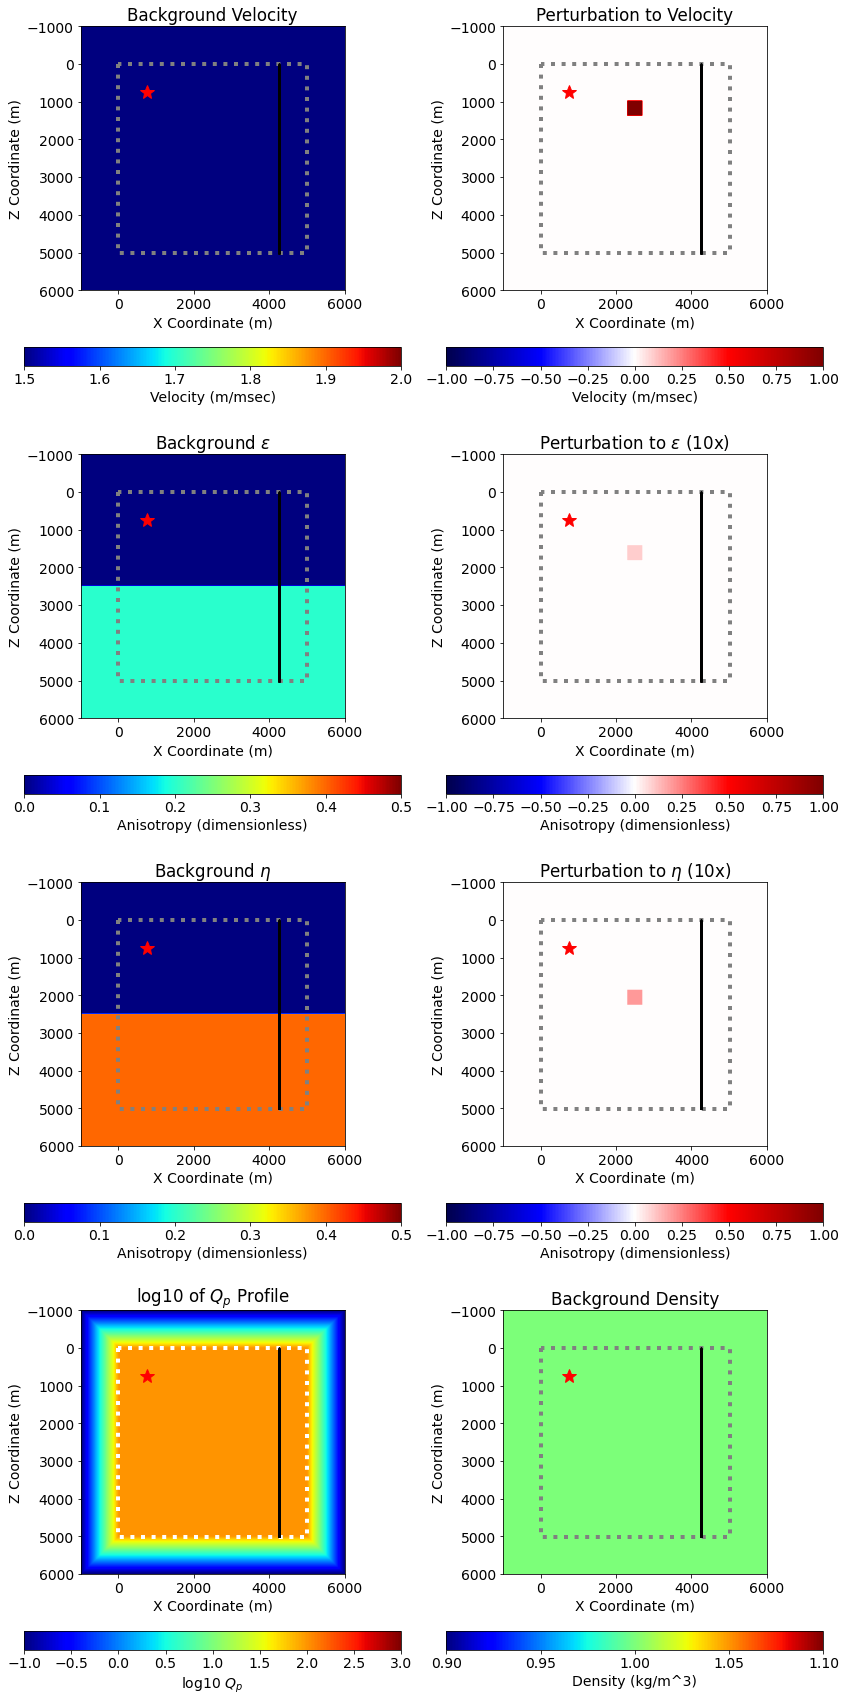

In [148]:
#NBVAL_INGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

vmin, vmax = 1.5, 2.0   # velocity min/max
amin, amax = 0.0, 0.5   # anisotropy min/max
bmin, bmax = 0.9, 1.1   # buoyancy min/max
dmin, dmax = -1, +1     # perturbation min/max

q = w / wOverQ.data[:]

x1 = 0.0
x2 = dx * nx
z1 = 0.0
z2 = dz * nz
abcX = [x1,x1,x2,x2,x1]
abcZ = [z1,z2,z2,z1,z1]

plt.figure(figsize=(12,24))

# Background model parameters
plt.subplot(4, 2, 1)
plt.imshow(np.transpose(vel0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Velocity")

plt.subplot(4, 2, 3)
plt.imshow(np.transpose(eps0.data), cmap=cm.jet, 
           vmin=amin, vmax=amax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background $\epsilon$")

plt.subplot(4, 2, 5)
plt.imshow(np.transpose(eta0.data), cmap=cm.jet, 
           vmin=amin, vmax=amax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background $\eta$")

plt.subplot(4, 2, 7)
plt.imshow(np.transpose(np.log10(q.data)), cmap=cm.jet,
           vmin=np.log10(qmin), vmax=np.log10(qmax), extent=plt_extent)
plt.plot(abcX, abcZ, 'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='log10 $Q_p$')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q_p$ Profile")

# Perturbation parameters
plt.subplot(4, 2, 2)
plt.imshow(np.transpose(dvel.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to Velocity")

plt.subplot(4, 2, 4)
plt.imshow(np.transpose(10 * deps.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to $\epsilon$ (10x)")

plt.subplot(4, 2, 6)
plt.imshow(np.transpose(10 * deta.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to $\eta$ (10x)")

plt.subplot(4, 2, 8)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Density (kg/m^3)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Density")

plt.tight_layout()
None

## Define pressure wavefields

In this notebook we will first demonstrate the nonlinear operator, which requires only 3 time-levels for the second order time differencing. We will create  state variables for quasi-P and quasi-M nonlinear wavefields. 

For the workflow using the Jacobian operator below, we will need to save all time steps. There are other ways to implement this requirement, including checkpointing, but that is way outside the scope of this illustrative workflow.

In [149]:
# Define the TimeFunctions for nonlinear and Jacobian operations
nt = time_range.num
p0 = TimeFunction(name="p0", grid=grid, time_order=2, 
                  space_order=space_order, save=None)
s0 = TimeFunction(name="s0", grid=grid, time_order=2, 
                  space_order=space_order, save=None)

# Get the dimensions for t, x, z 
t,x,z = p0.dimensions

## Create a re-usable function to return the VTI stencil

We next transcribe the time update stencil for the nonlinear operator above into a Devito ```Eq```. 

Recall that this same stencil can be used for the nonlinear operator and the linearized forward and adjoint Jacobian operators, with the only changes required in the supplied source terms $q_p, q_s$. We will take advantage of Devito's **placeholder design pattern** to change these source terms below. 

We also simplify the expression above to 2D and reproduce below for comparison with the stencil.

$$
\begin{aligned}
p(t+\Delta_t) = \frac{\Delta_t^2\ v^2}{b} \biggl\{ 
  &+ \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ \bigl(g_1\ p(t)\bigr) \biggr] \\[5pt]
  &+ \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr) \bigl(g_3\ p(t)\bigr) + 
        b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ s(t)\bigr) \biggr] + q_p 
\biggr\} \\[5pt]
  &+ \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ p(t) 
   + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ p(t-\Delta_t)\\[20pt]
s(t+\Delta_t) = \frac{\Delta_t^2\ v^2}{b} \biggl\{ 
  &+ \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ s(t)\bigr) \biggr] \\[5pt]
  &+ \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ \bigl(g_3\ s(t)\bigr) + 
        b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ \bigl(g_3\ p(t)\bigr) \biggr] + q_s
\biggr\} \\[5pt]
  & + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ s(t) 
    + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ s(t-\Delta_t)
\end{aligned}
$$


In [150]:
# Define stencil for VTI operators
def vti_stencil(p, s, q_p, q_s, **kwargs):
    """
    Time update tencil for the scalar VTI anisotropic visco- acoustic variable 
    density skew self adjoint wave equation. 

    Wave equation:
        b/v^2 [ p.dt2 + w/Q p.dt ] = 
            g1'[b (1 - 2 eps) g1(p)] + 
            g2'[b (1 + 2 eps) g2(p)] + 
            g3'[b (1 - f eta^2) g3(p) + b f eta sqrt(1 - eta^2) g3(s)] + q_p

        b/v^2 [ s.dt2 + w/Q s.dt ] = 
            g1'[b (1 - 2 eps) g1(s)] + 
            g2'[b (1 + 2 eps) g2(s)] + 
            g3'[b (1 - f eta^2) g3(s) + b f eta sqrt(1 - eta^2) g3(p)] + q_s

        where:
            g1, g1': 1/2 cell forward,backward shifted X derivatives 
            g2, g2': 1/2 cell forward,backward shifted Y derivatives 
            g3, g3': 1/2 cell forward,backward shifted Z derivatives 

    Parameters
    ----------
    p : TimeFunction, required
        The quasi-P pressure wavefield computed solution.
    s : TimeFunction, required 
        The quasi-S pressure wavefield computed solution.
    q_p : TimeFunction, Function or float
        Full-space/time quasi-P source of the wave-equation.
    q_s : TimeFunction, Function or float
        Full-space/time quasi-S source of the wave-equation.
    forward : bool, optional
        The propagation direction. Defaults to True.

    Returns
    ----------
    The time update stencil for quasi-P and quasi-S state variables.
    """
    
    # Define time step of pressure wavefield to be updated
    forward = kwargs.get('forward', True)

    if forward:
        p_next = p.forward
        p_prev = p.backward
        s_next = s.forward
        s_prev = s.backward
    else:
        p_next = p.backward
        p_prev = p.forward
        s_next = s.backward
        s_prev = s.forward

    update_p = t.spacing**2 * vel0**2 / b * \
        (g1_tilde(b * (1 + 2 * eps0) * g1(p)) +
         g3_tilde(b * (1 - f * eta0**2) * g3(p) + 
                  b * f * eta0 * sqrt(1 - eta0**2) * g3(s)) + q_p) + \
        (2 - t.spacing * wOverQ) * p + (t.spacing * wOverQ - 1) * p_prev

    # Time update equation for quasi-S state variable m
    update_s = t.spacing**2 * vel0**2 / b * \
        (g1_tilde(b * (1 - f) * g1(s)) +
         g3_tilde(b * (1 - f + f * eta0**2) * g3(s) + 
                  b * f * eta0 * sqrt(1 - eta0**2) * g3(p)) + q_s) + \
        (2 - t.spacing * wOverQ) * s + (t.spacing * wOverQ - 1) * s_prev

    stencil_p = Eq(p_next, update_p)
    stencil_s = Eq(s_next, update_s)
    
    return stencil_p, stencil_s

## Instantiate the nonlinear operator

For the nonlinear operator we inject the source and extract the receiver wavefield via  ```SparseTimeFunction```. We defined above ```src``` as a Ricker wavelet and ```rec``` as a line of receivers, and below make source injection and receiver interpolation as Devito ```Eq``` that we pass to the nonlinear operator. This means that the placeholder symbols q_p and q_s are set to zero.

Please refer to the implementation shown in the first notebook for more information. 

In [151]:
#NBVAL_IGNORE_OUTPUT
q_p = 0
q_s = 0
stencil_p, stencil_s = vti_stencil(p0, s0, q_p, q_s, forward=True)

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Source injection and Receiver extraction
src_term = src.inject(field=p0.forward, expr=src * t.spacing**2 * vel0**2 / b)
rec_term = rec.interpolate(expr=p0.forward)

# Instantiate and run the operator for the nonlinear forward
# op = Operator([stencil_p, stencil_s, src_term, rec_term], subs=spacing_map)
op = Operator([stencil_p, stencil_s, src_term], subs=spacing_map)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 1.0}


Operator `Kernel` generated in 2.87 s
  * lowering.Expressions: 1.38 s (48.3 %)
  * lowering.Clusters: 1.16 s (40.6 %)
Flops reduction after symbolic optimization: [1052 --> 233]


## Run modeling for isotropic, elliptic, and full anisotropic

As in the first isotropic notebook, we can run the operator multiple times and supply different ```TimeFunction``` and ```Function``` to generate and save the different results. In order to do this we take advantage of Devito's **placeholder design pattern** and supply replacements for the parts of the stencil we wish to override. 

We will also create ```Function``` with zero values in order to generate results for the isotropic example. The three cases are enumerated in the table below. 

#### Material parameters for the 3 cases 
$\tilde{\eta}$ is defined as above and must be strictly greater than or equal to $\delta$ in order to avoid the square root becoming imaginary.

$$
\tilde{\eta} = \sqrt{\frac{\displaystyle 2\bigl(\epsilon - \delta\bigr)}{\displaystyle f + 2\ \epsilon}}
$$
<br>

<!-- | Case | &nbsp; &nbsp; Velocity &nbsp; &nbsp; | &nbsp; &nbsp; $\epsilon$ &nbsp; &nbsp; | &nbsp; &nbsp; $\delta$ &nbsp; &nbsp; | &nbsp; &nbsp; $\tilde{\eta}$ &nbsp; &nbsp; |
 -->
| Case | Velocity | $\epsilon$ | $\delta$ | $\tilde{\eta}$ |
| :--- | :---: | :---: | :---: | :---: |
| Isotropic | 1.50 | 0.00 | 0.00 | 0.00 | 
| Elliptical Anisotropic | 1.50 | 0.20 | 0.20 | 0.0 | 
| Full Anisotropic | 1.50 | 0.20 | 0.10 | 0.40 | 


In [152]:
# Define TimeFunctions and Functions for isotropic 
p_iso = TimeFunction(name="p_iso", grid=grid, time_order=2, space_order=space_order, save=None)
s_iso = TimeFunction(name="s_iso", grid=grid, time_order=2, space_order=space_order, save=None)
eps_iso = Function(name='eps_iso', grid=grid, space_order=space_order)
eta_iso = Function(name='eta_iso', grid=grid, space_order=space_order)
eps_iso.data[:] = 0.0
eta_iso.data[:] = 0.0

# Define TimeFunctions and Functions for elliptic anisotropic 
p_ell = TimeFunction(name="p_ell", grid=grid, time_order=2, space_order=space_order, save=None)
s_ell = TimeFunction(name="s_ell", grid=grid, time_order=2, space_order=space_order, save=None)
eps_ell = Function(name='eps_ell', grid=grid, space_order=space_order)
eta_ell = Function(name='eta_ell', grid=grid, space_order=space_order)
eps_ell.data[:] = eps0.data[:]
eta_ell.data[:] = 0.0

# Define TimeFunctions and Functions for full anisotropic 
p_full = TimeFunction(name="p_full", grid=grid, time_order=2, space_order=space_order, save=None)
s_full = TimeFunction(name="s_full", grid=grid, time_order=2, space_order=space_order, save=None)
eps_full = Function(name='eps_full', grid=grid, space_order=space_order)
eta_full = Function(name='eta_full', grid=grid, space_order=space_order)
eps_full.data[:] = eps0.data[:]
eta_full.data[:] = eta0.data[:]

Allocating memory for eps_iso(717, 717)
Allocating memory for eta_iso(717, 717)
Allocating memory for eps_ell(717, 717)
Allocating memory for eta_ell(717, 717)
Allocating memory for eps_full(717, 717)
Allocating memory for eta_full(717, 717)


In [153]:
#NBVAL_INGNORE_OUTPUT

# Modeling
op.apply(p0=p_iso, s0=s_iso, eps0=eps_iso, eta0=eta_iso)
op.apply(p0=p_ell, s0=s_ell, eps0=eps_ell, eta0=eta_ell)
op.apply(p0=p_full, s0=s_full, eps0=eps_full, eta0=eta_full)

None

Allocating memory for p_iso(3, 717, 717)
Allocating memory for s_iso(3, 717, 717)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/5944a67ed6598a966d517ab2ff656a53ffad9035.c` in 0.23 s from jit-cache
Operator `Kernel` run in 3.66 s
Global performance indicators
  * Achieved 0.34 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [0.46 GFlops/s]
  * section1<<2499,708,708>,<2499,701,701>> with OI=2.59 computed in 3.57 s [79.63 GFlops/s, 0.69 GPts/s]
  * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> with OI=3.85 computed in 0.09 s [0.01 GFlops/s, 0.01 GPts/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}
Allocating memory for p_ell(3, 717, 717)
Allocating memory for s_ell(3, 717, 717)
Operator `Kernel` run in 3.69 s
Global performance indicators
  * Achieved 0.33 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [2.88 GFlops/s]
  * section1<<2499,708,708

In [154]:
# Report min/max amplitudes
n = 1

p_iso_min,p_iso_max = np.min(p_iso.data[n,:,:]), np.max(p_iso.data[n,:,:])
s_iso_min,s_iso_max = np.min(s_iso.data[n,:,:]), np.max(s_iso.data[n,:,:])

p_ell_min,p_ell_max = np.min(p_ell.data[n,:,:]), np.max(p_ell.data[n,:,:])
s_ell_min,s_ell_max = np.min(s_ell.data[n,:,:]), np.max(s_ell.data[n,:,:])

p_full_min,p_full_max = np.min(p_full.data[n,:,:]), np.max(p_full.data[n,:,:])
s_full_min,s_full_max = np.min(s_full.data[n,:,:]), np.max(s_full.data[n,:,:])

print("ISO  pmin,pmax,smin,smax; %+12.6e %+12.6e %+12.6e %+12.6e" % \
      (p_iso_min, p_iso_max, s_iso_min, s_iso_max))
print("ELL  pmin,pmax,smin,smax; %+12.6e %+12.6e %+12.6e %+12.6e" % \
      (p_ell_min, p_ell_max, s_ell_min, s_ell_max))
print("FULL pmin,pmax,smin,smax; %+12.6e %+12.6e %+12.6e %+12.6e" % \
      (p_full_min, p_full_max, s_full_min, s_full_max))

ISO  pmin,pmax,smin,smax; -4.600849e-01 +7.553645e-01 +0.000000e+00 +0.000000e+00
ELL  pmin,pmax,smin,smax; -6.924947e-01 +1.191348e+00 +0.000000e+00 +0.000000e+00
FULL pmin,pmax,smin,smax; -7.064285e-01 +1.201524e+00 -5.435909e-01 +3.076607e-01


## Plot the quasi-P and quasi-S nonlinear forward wavefields

Below we show the quasi-P nonlinear wavefields for the 3 different cases at the end of the modeling. We also show the quasi-S nonlinear wavefield for the full anisotropic case. You can observe from the amplitude extreme printed in the cell above that the quasi-S wavefield are zero for the isotropic and elliptical cases as nothing is coupled from quasi-P to quasi-S wavefields when $\tilde{\eta}$ is zero. 

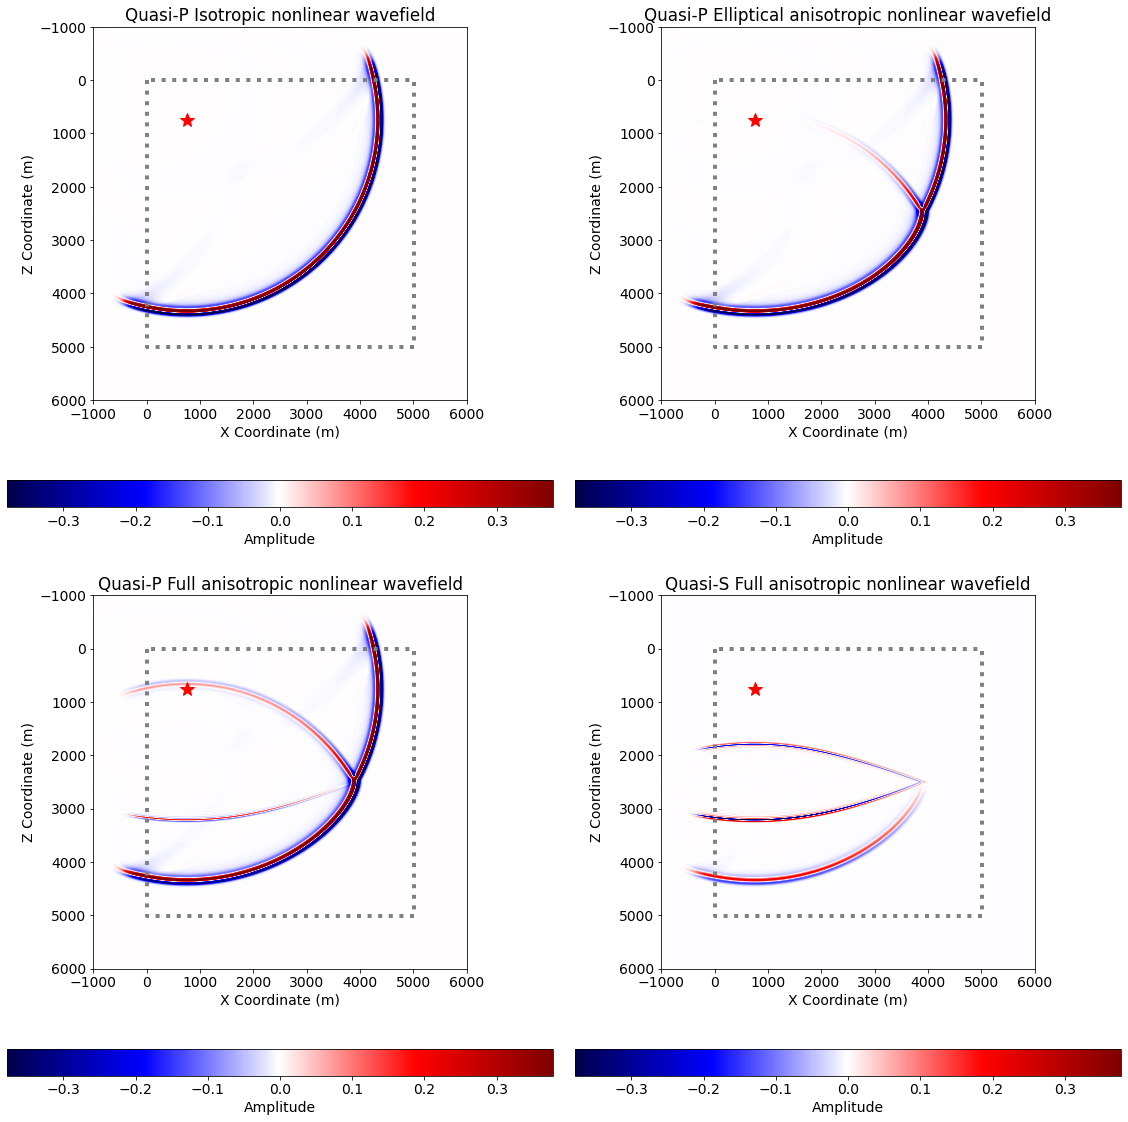

In [155]:
#NBVAL_INGNORE_OUTPUT

amax1 = np.max(np.abs(p_iso.data[1,:,:])) / 2.0

plt.figure(figsize=(16,16))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(p_iso.data[1,:,:]), cmap="seismic", 
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P Isotropic nonlinear wavefield")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(p_ell.data[1,:,:]), cmap="seismic",
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P Elliptical anisotropic nonlinear wavefield")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(p_full.data[1,:,:]), cmap="seismic",
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P Full anisotropic nonlinear wavefield")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(s_full.data[1,:,:]), cmap="seismic",
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-S Full anisotropic nonlinear wavefield")

plt.tight_layout()
None

## Workflow for implementing the linearized operators

The Jacobian linearized ops require that we have saved all the computed time steps from the nonlinear forward wavefield to use for the Born source terms. This means we need to regenerate ```TimeFunction``` for quasi-P and quasi-S state variables that save the entire time history. We will also create a function for the VTI stencil that can be used both for the nonlinear and linear ops.

In this implementation, we use the same stencil for both the nonlinear and linearized operators. This is possible because we pass the **symbols** for $q_p, q_s$ to the stencil function, and supply different values for the two cases as shown in the table below.

| Operator | Wavefield | Source | Value | 
| :---: | :---: | :---: | :---: |
| Nonlinear | quasi-P | $q_p$ | 0 | 
| Nonlinear | quasi-S | $q_s$ | 0 | 
| Linearized | quasi-P | $q_p$ | $\bigl[\texttt{Born p}\bigr]$ | 
| Linearized | quasi-S | $q_s$ | $\bigl[\texttt{Born s}\bigr]$ | 


#### Outline for the following work:
1. Create ```TimeFunctions``` for p0, s0, that save all time steps (required for linearization)
1. Create ```TimeFunctions``` for dp, ds, that do not save time steps
1. Use the VTI stencil function defined above to generate the nonlinear time update equation, supplying zero fpr $q_p, q_s$
1. Run the nonlinear forward to save the time history for $p_0, s_0$
1. Use the VTI stencil function defined above to generate the linearized Jacobian forward time update equation, supplying the Born source terms for $q_p, q_s$
1. Collect all equations for nonlinear time update, linearized time update, nonlinear source, and linearized Born source with the correct precendence and build the Devito ```Operator```
1. profit

#### TimeFunctions for nonlinear and linear operators

In [156]:
# Define the TimeFunctions for nonlinear and Jacobian operations
p0 = TimeFunction(name="p0", grid=grid, time_order=2, space_order=space_order, save=nt)
s0 = TimeFunction(name="s0", grid=grid, time_order=2, space_order=space_order, save=nt)
dp = TimeFunction(name="dp", grid=grid, time_order=2, space_order=space_order, save=None)
ds = TimeFunction(name="ds", grid=grid, time_order=2, space_order=space_order, save=None)

# Get the dimensions for t, x, z 
t,x,z = p0.dimensions

#### Build nonlinear forward ```Operator``` and run  

In [157]:
#NBVAL_IGNORE_OUTPUT
q_p = 0
q_s = 0
stencil_p_nl, stencil_s_nl = vti_stencil(p0, s0, q_p, q_s, forward=True)

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Source injection and Receiver extraction 
src_term = src.inject(field=p0.forward, expr=src * t.spacing**2 * vel0**2 / b)
rec_term = rec.interpolate(expr=p0.forward)

# Instantiate and run the operator for the nonlinear forward
op_nl = Operator([stencil_p_nl, stencil_s_nl, src_term, rec_term], subs=spacing_map)
op_nl.apply()
None

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 1.0}


Operator `Kernel` generated in 2.94 s
  * lowering.Expressions: 1.43 s (48.7 %)
  * lowering.Clusters: 1.12 s (38.2 %)
Flops reduction after symbolic optimization: [1052 --> 233]
Allocating memory for p0(2501, 717, 717)
Allocating memory for rec(2501, 501)
Allocating memory for s0(2501, 717, 717)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/33006a6aadc1f746dd184d68ddbe23676564f429.c` in 0.25 s from jit-cache
Operator `Kernel` run in 4.29 s
Global performance indicators
  * Achieved 0.29 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [0.27 GFlops/s]
  * section1<<2499,708,708>,<2499,701,701>> with OI=2.59 computed in 3.85 s [73.95 GFlops/s, 0.64 GPts/s]
  * section2<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> with OI=3.85 computed in 0.26 s [0.01 GFlops/s, 0.01 GPts/s]
  * section3<<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>> with OI=4.84 computed in 0.18 s [0.42 GFlops/s]
Performance[mode=advanced] argumen

#### Time update equations for the linearized Jacobian forward 

We will solve the VTI PDE for the perturbation wavefields $\delta p, \delta s$:

$$
\begin{aligned}
\delta p(t+\Delta_t) &= \frac{\Delta_t^2\ v^2}{b} \biggl\{ 
    \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ \bigl(g_1\ \delta p(t)\bigr) \biggr] \\[5pt] 
  & \qquad\qquad + \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}_0^2\bigr) \bigl(g_3\ \delta p(t)\bigr) + 
        b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \delta s(t)\bigr) \biggr] 
        + \bigl[ \texttt{Born p}\bigr] \biggr\}\\[5pt]
  & \qquad\qquad
    + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ \delta p(t) 
    + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ \delta p(t-\Delta_t)
\\[20pt]
\delta s(t+\Delta_t) &= \frac{\Delta_t^2\ v^2}{b} \biggl\{ 
    \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ \delta s(t)\bigr) \biggr] \\[5pt]
  & \qquad\qquad + \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}_0^2\bigr)\ \bigl(g_3\ \delta s(t)\bigr) + 
        b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \delta p(t)\bigr) \biggr]
        + \bigl[ \texttt{Born s}\bigr] \biggr\} \\[5pt]
  & \qquad\qquad  
    + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ \delta s(t) 
    + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ \delta s(t-\Delta_t) 
\end{aligned}
$$

For the linearized equations we use the Born source terms to replace $q_p, q_s$:

$$
\begin{aligned}
\bigl[ \texttt{Born p}\bigr] =\ & \frac{2\ b\ \delta v}{v_0^3} L_t[p_0] 
    + \tilde{g}_1 \biggl[ 2\ b\ \delta \epsilon\ \bigl(g_1\ p_0\bigr) \biggr]
    + \tilde{g}_2 \biggl[ 2\ b\ \delta \epsilon\ \bigl(g_2\ p_0\bigr) \biggr] \\[5pt]
  &\quad + \tilde{g}_3 \biggl[ 
    - 2\ b\ f\ \tilde{\eta}_0\ \delta \tilde{\eta}\ \bigl(g_3\ p_0\bigr) 
    + \frac{b\ f\ \bigl(1 - 2\ \tilde{\eta}_0^2 \bigr)}{\sqrt{1 - \tilde{\eta}_0^2} }\ \bigl(g_3\ s_0\bigr)
    \biggr]
\\[15pt]
\bigl[ \texttt{Born s}\bigr] =\ & \frac{2\ b\ \delta v}{v_0^3} L_t[s_0] \\[5pt]
  &\quad + \tilde{g}_3 \biggl[ 
    + 2\ b\ f\ \tilde{\eta}_0\ \delta \tilde{\eta}\ \bigl(g_3\ s_0\bigr)
    + \frac{b\ f\ \bigl(1 - 2\ \tilde{\eta}_0^2 \bigr)}{\sqrt{1 - \tilde{\eta}_0^2} }\ \bigl(g_3\ p_0\bigr)
    \biggr]
\end{aligned}
$$

Recall the definition of $L_t[\cdot]$, used in the Born source terms:

$$
L_t[\cdot] \equiv \frac{\omega_c}{Q} \overleftarrow{\partial_t}[\cdot] + \partial_{tt}[\cdot]
$$


In [158]:
#NBVAL_IGNORE_OUTPUT
q_p = (2 * b * dvel / vel0**3) * (wOverQ * p0.dt(x0=t-t.spacing/2) + p0.dt2) + \
    g1_tilde(+2 * b * deps * g1(p0)) + \
    g3_tilde(-2 * b * f * eta0 * deta * g3(p0) + 
             b * f * (1 - 2 * eta0**2) * g3(s0) / (sqrt(1 - eta0**2))) 

q_s = (2 * b * dvel / vel0**3) *  (wOverQ * s0.dt(x0=t-t.spacing/2) + s0.dt2) + \
    g3_tilde(+2 * b * f * eta0 * deta * g3(s0) + 
             b * f * (1 - 2 * eta0**2) * g3(p0) / (sqrt(1 - eta0**2))) 

stencil_p_ln_fwd, stencil_s_ln_fwd = vti_stencil(dp, ds, q_p, q_s)

#### Build linearized Jacobian forward ```Operator``` and run

Like we did previously, we will make four runs for the various combinations of model perturbation enumerated in the table below.

| Experiment | $\delta v$ | $\delta \epsilon$ | $\delta \tilde{\eta}$ |
| :---: | :---: | :---: | :---: |
| 1 | $\delta v$ | 0 | 0 | 
| 2 | 0 | $\delta \epsilon$ | 0 | 
| 3 | 0 | 0 | $\delta \tilde{\eta}$ | 
| 4 | $\delta v$ | $\delta \epsilon$ | $\delta \tilde{\eta}$ | 

In [159]:
# Define TimeFunctions for experiments 
dp1 = TimeFunction(name="dp1", grid=grid, time_order=2, space_order=space_order, save=None)
dp2 = TimeFunction(name="dp2", grid=grid, time_order=2, space_order=space_order, save=None)
dp3 = TimeFunction(name="dp3", grid=grid, time_order=2, space_order=space_order, save=None)
dp4 = TimeFunction(name="dp4", grid=grid, time_order=2, space_order=space_order, save=None)

ds1 = TimeFunction(name="ds1", grid=grid, time_order=2, space_order=space_order, save=None)
ds2 = TimeFunction(name="ds2", grid=grid, time_order=2, space_order=space_order, save=None)
ds3 = TimeFunction(name="ds3", grid=grid, time_order=2, space_order=space_order, save=None)
ds4 = TimeFunction(name="ds4", grid=grid, time_order=2, space_order=space_order, save=None)

# Define receivers for experiments
rec1 = Receiver(name='rec1', grid=grid, npoint=nz, time_range=time_range, coordinates=rec.coordinates.data)
rec2 = Receiver(name='rec2', grid=grid, npoint=nz, time_range=time_range, coordinates=rec.coordinates.data)
rec3 = Receiver(name='rec3', grid=grid, npoint=nz, time_range=time_range, coordinates=rec.coordinates.data)
rec4 = Receiver(name='rec4', grid=grid, npoint=nz, time_range=time_range, coordinates=rec.coordinates.data)

# Define zero Function for experiments 
zero = Function(name='zero', grid=grid, space_order=space_order)

Allocating memory for rec1_coords(501, 2)
Allocating memory for rec2_coords(501, 2)
Allocating memory for rec3_coords(501, 2)
Allocating memory for rec4_coords(501, 2)


In [160]:
#NBVAL_IGNORE_OUTPUT

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Receiver extraction 
rec_term = rec.interpolate(expr=dp.forward)

# Instantiate and run the operator for the nonlinear forward
op_ln_fwd = Operator([stencil_p_ln_fwd, stencil_s_ln_fwd, rec_term], subs=spacing_map)

op_ln_fwd.apply(dp=dp1, ds=ds1, dvel=dvel, deps=zero, deta=zero, rec=rec1)
op_ln_fwd.apply(dp=dp2, ds=ds2, dvel=zero, deps=deps, deta=zero, rec=rec2)
op_ln_fwd.apply(dp=dp3, ds=ds3, dvel=zero, deps=zero, deta=deta, rec=rec3)
op_ln_fwd.apply(dp=dp4, ds=ds4, dvel=dvel, deps=deps, deta=deta, rec=rec4)

None

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 1.0}


Operator `Kernel` generated in 4.86 s
  * lowering.Expressions: 2.51 s (51.7 %)
  * lowering.Clusters: 1.87 s (38.5 %)
     * specializing.Clusters: 1.32 s (27.2 %)
Flops reduction after symbolic optimization: [1970 --> 498]
Allocating memory for zero(717, 717)
Allocating memory for dp1(3, 717, 717)
Allocating memory for ds1(3, 717, 717)
Allocating memory for rec1(2501, 501)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/fcc745e48f55243611886c1bf1daa40b7253fb0d.c` in 0.34 s from jit-cache
Operator `Kernel` run in 11.09 s
Global performance indicators
  * Achieved 0.11 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [0.45 GFlops/s]
  * section1<<2499,708,708>,<2499,701,701>> with OI=3.31 computed in 10.80 s [56.57 GFlops/s, 0.23 GPts/s]
  * section2<<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>> with OI=4.84 computed in 0.28 s [0.27 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffi

In [165]:
# Report min/max amplitudes
dp1_min,dp1_max = np.min(dp1.data[1,:,:]), np.max(dp1.data[1,:,:])
dp2_min,dp2_max = np.min(dp2.data[1,:,:]), np.max(dp2.data[1,:,:])
dp3_min,dp3_max = np.min(dp3.data[1,:,:]), np.max(dp3.data[1,:,:])
dp4_min,dp4_max = np.min(dp4.data[1,:,:]), np.max(dp4.data[1,:,:])

dr1_min,dr1_max = np.min(rec1.data[:]), np.max(rec1.data[:])
dr2_min,dr2_max = np.min(rec2.data[:]), np.max(rec2.data[:])
dr3_min,dr3_max = np.min(rec3.data[:]), np.max(rec3.data[:])
dr4_min,dr4_max = np.min(rec4.data[:]), np.max(rec4.data[:])

print(" ")
print("p min; %+12.6e %+12.6e %+12.6e %+12.6e" % (dp1_min, dp1_min, dp3_min, dp4_min))
print("p max; %+12.6e %+12.6e %+12.6e %+12.6e" % (dp1_max, dp1_max, dp3_max, dp4_max))

print(" ")
print("r min; %+12.6e %+12.6e %+12.6e %+12.6e" % (dr1_min, dr1_min, dr3_min, dr4_min))
print("r max; %+12.6e %+12.6e %+12.6e %+12.6e" % (dr1_max, dr1_max, dr3_max, dr4_max))

 
p min; -2.397009e+01 -2.397009e+01 -2.397002e+01 -2.397006e+01
p max; +2.316308e+01 +2.316308e+01 +2.316299e+01 +2.316303e+01
 
r min; -6.147583e+00 -6.147583e+00 -3.980173e-11 -6.138553e+00
r max; +7.993510e+00 +7.993510e+00 +5.420230e-11 +7.986990e+00


## Plot the $\delta p$ wavefields for the four experiments

Below we show the quasi-P nonlinear wavefields for the 4 different experiments at the end of the modeling.

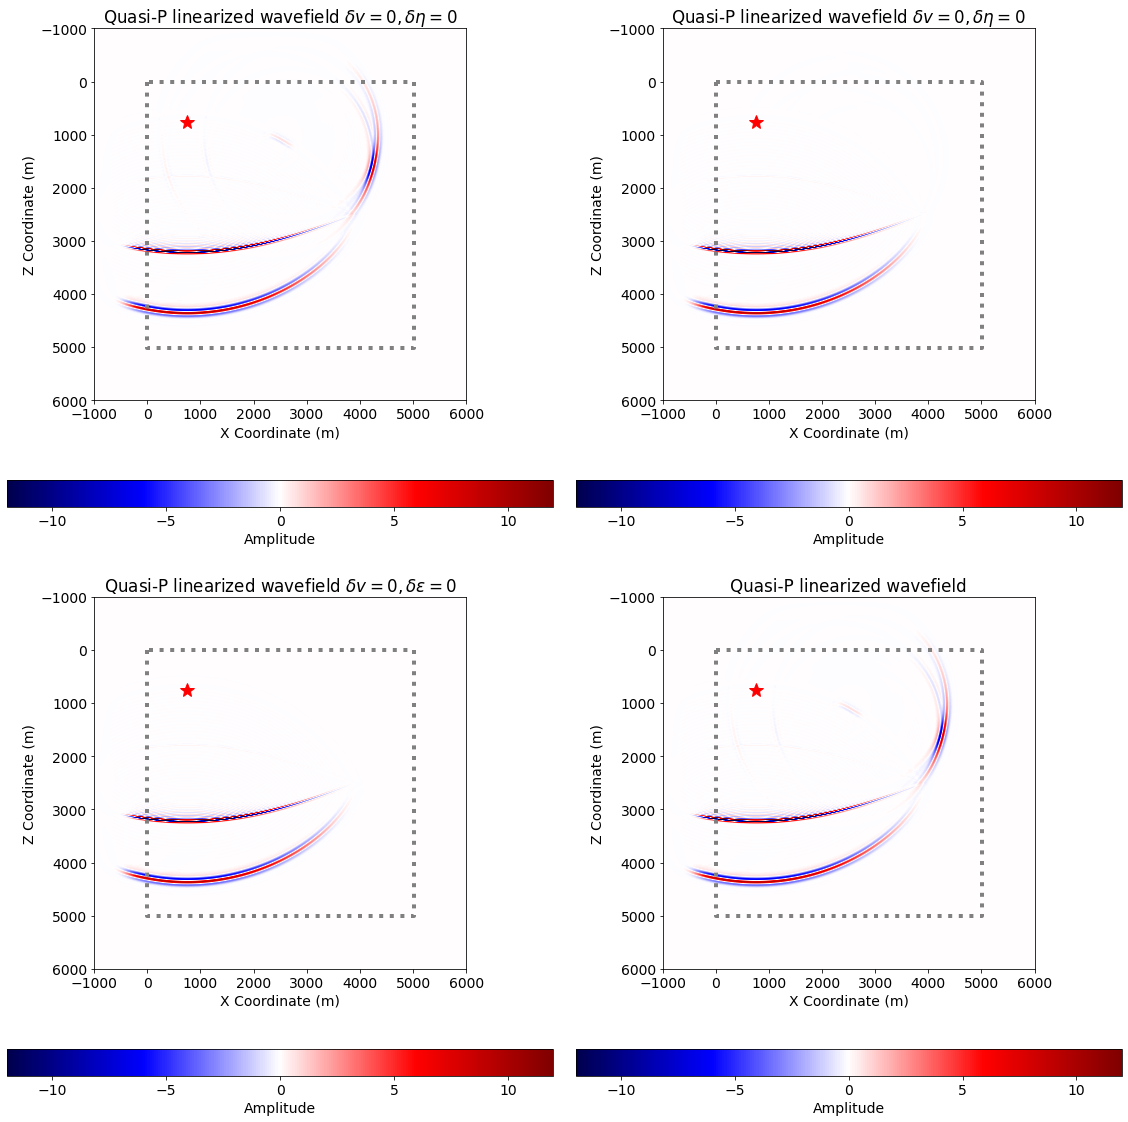

In [99]:
#NBVAL_INGNORE_OUTPUT
amax = np.max(np.abs(dp4.data[1,:,:])) / 2.0

plt.figure(figsize=(16,16))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(dp1.data[1,:,:]), cmap="seismic", 
           vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P linearized wavefield $\delta v = 0, \delta \eta = 0$")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(dp2.data[1,:,:]), cmap="seismic",
           vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P linearized wavefield $\delta v = 0,  \delta \eta = 0$")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dp3.data[1,:,:]), cmap="seismic",
           vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P linearized wavefield $\delta v = 0, \delta \epsilon = 0$")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(dp4.data[1,:,:]), cmap="seismic",
           vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P linearized wavefield")

plt.tight_layout()
None

## Plot the receiver wavefields for the four experiments

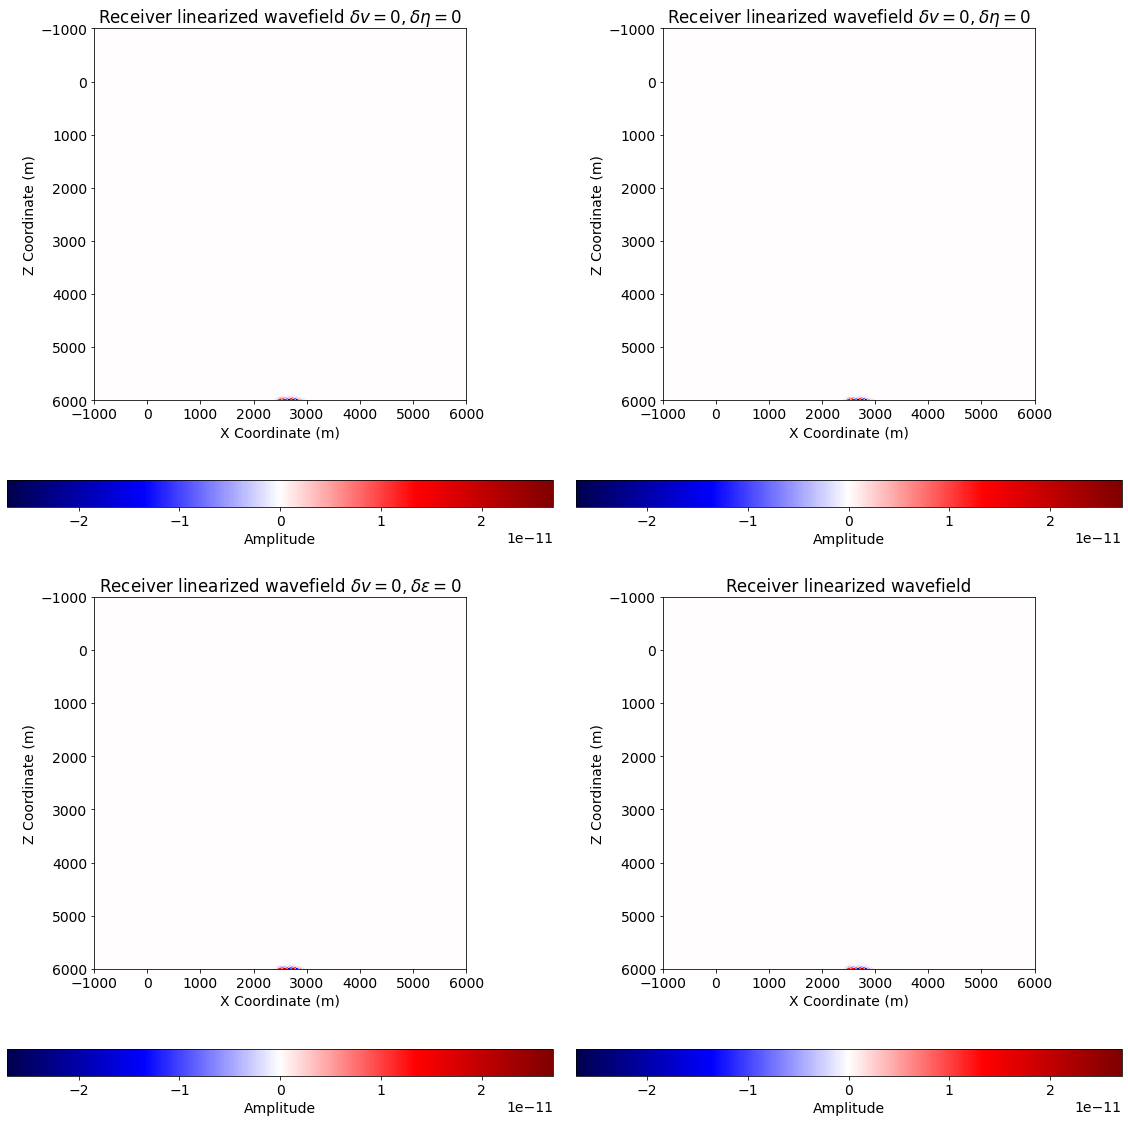

In [139]:
#NBVAL_INGNORE_OUTPUT
amax = np.max(np.abs(rec4.data[:])) / 2.0

plt.figure(figsize=(16,16))

plt.subplot(2, 2, 1)
plt.imshow(rec1.data, cmap="seismic", vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Receiver linearized wavefield $\delta v = 0, \delta \eta = 0$")

plt.subplot(2, 2, 2)
plt.imshow(rec1.data, cmap="seismic", vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Receiver linearized wavefield $\delta v = 0,  \delta \eta = 0$")

plt.subplot(2, 2, 3)
plt.imshow(rec1.data, cmap="seismic", vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Receiver linearized wavefield $\delta v = 0, \delta \epsilon = 0$")

plt.subplot(2, 2, 4)
plt.imshow(rec1.data, cmap="seismic", vmin=-amax, vmax=+amax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Receiver linearized wavefield")

plt.tight_layout()
None

## Implement and run the linearized Jacobian adjoint operator

For the Jacobian adjoint we use the same time update expression and solve the PDE time reversed for the perturbation wavefields $\widetilde{\delta p}, \widetilde{\delta s}$, with the receiver wavefield perturbation $\widetilde{\delta r}$ injected as the source term only in the quasi-P wavefield.

#### 1. Time update equations for the linearized Jacobian adjoint  

$$
\begin{aligned}
\widetilde{\delta p}(t+\Delta_t) &= \frac{\Delta_t^2\ v^2}{b} \biggl\{ 
    +\ \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ \bigl(g_1\ 
    \widetilde{\delta p}(t)\bigr) \biggr] \\[5pt]
& \qquad\qquad + \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}_0^2\bigr) \bigl(g_3\ \widetilde{\delta p}(t)\bigr) + 
        b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \widetilde{\delta s}(t)\bigr) \biggr] +
        \widetilde{\delta r} \biggr\} \\[5pt]
& \qquad\qquad + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ \widetilde{\delta p}(t)
    + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ \widetilde{\delta p}(t-\Delta_t) \\[20pt]
\delta s(t+\Delta_t) &= \frac{\Delta_t^2\ v^2}{b} \biggl\{ 
    +\ \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ \bigl(g_1\ \widetilde{\delta s}(t)\bigr) \biggr] \\[5pt] 
& \qquad\qquad + \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}_0^2\bigr)\ \bigl(g_3\ 
    \widetilde{\delta s}(t)\bigr) + 
        b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ \bigl(g_3\ \widetilde{\delta p}(t)\bigr) \biggr] \biggr\} \\[5pt]
& \qquad\qquad + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ \widetilde{\delta s}(t)
    + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ \widetilde{\delta s}(t-\Delta_t) 
\end{aligned}
$$


#### 2. Zero lag correlations $\rightarrow$ perturbations to material parameter   

We compute the perturbations to material parameters by zero lag correlation of the wavefield perturbations $\widetilde{\delta p}, \widetilde{\delta s}$ solved in step 1 with the following expressions copied here from above. 

$$
\begin{aligned}
\delta v(x,y,z) = &+ \frac{\displaystyle 2\ b}{\displaystyle v_0^3}\ \sum_t 
    \biggl\{ 
        \widetilde{\delta p}\ L_t[p_0] + \widetilde{\delta s}\ L_t[s_0]
    \biggr\}\\[20pt]
\delta \epsilon(x,y,z) = &- 2\ b\ \sum_t 
    \biggl\{ 
        \bigl( g_1\ p_0 \bigr)\ \bigl( g_1\ \widetilde{\delta p} \bigr)
        + \bigl( g_2\ p_0 \bigr)\ \bigl( g_2\ \widetilde{\delta p} \bigr)
    \biggr\}\\[20pt]
\delta \tilde{\eta}(x,y,z) = 
&+ b\ \sum_t \biggl\{ 
    \biggl[ 2\ f\ \tilde{\eta}_0\ \bigl(g_3\ p_0\bigr) - 
        \frac{f\left(1 - 2\ \tilde{\eta}_0^2\right)}{\sqrt{1 - \tilde{\eta}_0^2}} \bigl(g_3\ s_0\bigr) \biggr]\ 
            \bigl( g_3\ \widetilde{\delta p} \bigr)
    \biggr\}\\[5pt]
&- b\ \sum_t \biggl\{ 
    \biggl[ 2\ f\ \tilde{\eta}_0\ \bigl(g_3\ s_0\bigr) +
        \frac{f\left(1 - 2\ \tilde{\eta}_0^2\right)}{\sqrt{1 - \tilde{\eta}_0^2}} \bigl(g_3\ p_0\bigr) \biggr]\ 
            \bigl( g_3\ \widetilde{\delta s} \bigr)
    \biggr\}
\end{aligned}
$$

In [134]:
#NBVAL_IGNORE_OUTPUT

# Zero the material parameter perturbations prior to accumulation
dvel.data[:] = 0
deps.data[:] = 0
deta.data[:] = 0

# The linearized Jacobian adjoint time update stencil 
q_p = 0
q_s = 0
stencil_p_ln_adj, stencil_s_ln_adj = vti_stencil(dp, ds, q_p, q_s, forward=False)

# Zero lag correlation for velocity
dvel_eq = Eq(dvel, dvel + (2 * b * vel0**-3) * 
             (dp * (wOverQ * p0.dt(x0=t-t.spacing/2) + p0.dt2) +
              ds * (wOverQ * s0.dt(x0=t-t.spacing/2) + s0.dt2)))

# Zero lag correlation for epsilon
deps_eq = Eq(deps, deps - (2 * b) * g1(dp) * g1(p0))

# Zero lag correlation for eta
deta_eq = Eq(deta, deta +
             b * g3(dp) * (2 * f * eta0 * g3(p0) - f * (1 - 2 * eta0**2) * g3(s0) / sqrt(1 - eta0**2)) -
             b * g3(ds) * (2 * f * eta0 * g3(s0) + f * (1 - 2 * eta0**2) * g3(p0) / sqrt(1 - eta0**2)))

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Create functions to hold the computed perturbations to material parameters
dvel1 = Function(name='dvel1', grid=grid, space_order=space_order)
dvel2 = Function(name='dvel2', grid=grid, space_order=space_order)
dvel3 = Function(name='dvel3', grid=grid, space_order=space_order)
dvel4 = Function(name='dvel4', grid=grid, space_order=space_order)

deps1 = Function(name='deps1', grid=grid, space_order=space_order)
deps2 = Function(name='deps2', grid=grid, space_order=space_order)
deps3 = Function(name='deps3', grid=grid, space_order=space_order)
deps4 = Function(name='deps4', grid=grid, space_order=space_order)

deta1 = Function(name='deta1', grid=grid, space_order=space_order)
deta2 = Function(name='deta2', grid=grid, space_order=space_order)
deta3 = Function(name='deta3', grid=grid, space_order=space_order)
deta4 = Function(name='deta4', grid=grid, space_order=space_order)

# # Construct expression to inject the computed linearized Jacobian receiver values at dp(t-dt)
# rec_term = rec.inject(field=dp.backward, expr=rec * t.spacing**2 * vel0**2 / b)

# # Instantiate and run the operator for the nonlinear forward
# op_ln_adj = Operator([dvel_eq, deps_eq, deta_eq, 
#                       stencil_p_ln_adj, stencil_s_ln_adj, rec_term], subs=spacing_map)

# op_ln_adj.apply(dvel=dvel1, deps=deps1, deta=deta1, dp=dp1)
# op_ln_adj.apply(dvel=dvel2, deps=deps2, deta=deta2, dp=dp2)
# op_ln_adj.apply(dvel=dvel3, deps=deps3, deta=deta3, dp=dp3)
# op_ln_adj.apply(dvel=dvel4, deps=deps4, deta=deta4, dp=dp4)

rec_term1 = rec.inject(field=dp1.backward, expr=rec * t.spacing**2 * vel0**2 / b)
rec_term2 = rec.inject(field=dp2.backward, expr=rec * t.spacing**2 * vel0**2 / b)
rec_term3 = rec.inject(field=dp3.backward, expr=rec * t.spacing**2 * vel0**2 / b)
rec_term4 = rec.inject(field=dp4.backward, expr=rec * t.spacing**2 * vel0**2 / b)

op_ln_adj1 = Operator([dvel_eq, deps_eq, deta_eq, 
                       stencil_p_ln_adj, stencil_s_ln_adj, rec_term1], subs=spacing_map)
op_ln_adj2 = Operator([dvel_eq, deps_eq, deta_eq, 
                       stencil_p_ln_adj, stencil_s_ln_adj, rec_term2], subs=spacing_map)
op_ln_adj3 = Operator([dvel_eq, deps_eq, deta_eq, 
                       stencil_p_ln_adj, stencil_s_ln_adj, rec_term3], subs=spacing_map)
op_ln_adj4 = Operator([dvel_eq, deps_eq, deta_eq, 
                       stencil_p_ln_adj, stencil_s_ln_adj, rec_term4], subs=spacing_map)

op_ln_adj1.apply(dvel=dvel1, deps=deps1, deta=deta1, dp=dp1)
op_ln_adj2.apply(dvel=dvel2, deps=deps2, deta=deta2, dp=dp2)
op_ln_adj3.apply(dvel=dvel3, deps=deps3, deta=deta3, dp=dp3)
op_ln_adj4.apply(dvel=dvel4, deps=deps4, deta=deta4, dp=dp4)

None

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 1.0}


Operator `Kernel` generated in 3.25 s
  * lowering.Expressions: 1.57 s (48.4 %)
  * lowering.Clusters: 1.26 s (38.8 %)
     * specializing.Clusters: 0.68 s (21.0 %)
Flops reduction after symbolic optimization: [1220 --> 321]
Operator `Kernel` generated in 2.21 s
  * lowering.Clusters: 1.24 s (56.2 %)
     * specializing.Clusters: 0.91 s (41.3 %)
        * cire: 0.66 s (30.0 %)
  * lowering.Expressions: 0.55 s (25.0 %)
Flops reduction after symbolic optimization: [1220 --> 321]
Operator `Kernel` generated in 2.18 s
  * lowering.Clusters: 1.22 s (56.0 %)
     * specializing.Clusters: 0.88 s (40.4 %)
  * lowering.Expressions: 0.55 s (25.3 %)
Flops reduction after symbolic optimization: [1220 --> 321]
Operator `Kernel` generated in 1.99 s
  * lowering.Clusters: 1.01 s (50.9 %)
     * specializing.Clusters: 0.67 s (33.8 %)
        * cire: 0.43 s (21.7 %)
  * lowering.Expressions: 0.57 s (28.7 %)
Flops reduction after symbolic optimization: [1220 --> 321]
Allocating memory for deps1(717, 717

gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /tmp/devito-jitcache-uid5138/65398fd1c59071bb03cc2849e865198b9ae96703.c -lm -o /tmp/devito-jitcache-uid5138/65398fd1c59071bb03cc2849e865198b9ae96703.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid5138/65398fd1c59071bb03cc2849e865198b9ae96703.c` in 1.26 s with `GNUCompiler`
Operator `Kernel` run in 6.78 s
Global performance indicators
  * Achieved 0.18 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [0.33 GFlops/s]
  * section1<<2499,708,708>,<2499,701,701>> with OI=2.63 computed in 6.56 s [59.79 GFlops/s, 0.38 GPts/s]
  * section2<<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>> with OI=3.85 computed in 0.21 s [0.47 GFlops/s, 0.03 GPts/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}
Allocating memory for deps2(717, 717)
Allocating memory for deta2(717, 717)
Allocating memory for dvel2(717, 717)


gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /tmp/devito-jitcache-uid5138/7194a5d347bcc5d4ab86d4b1143de27c228e247f.c -lm -o /tmp/devito-jitcache-uid5138/7194a5d347bcc5d4ab86d4b1143de27c228e247f.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid5138/7194a5d347bcc5d4ab86d4b1143de27c228e247f.c` in 1.24 s with `GNUCompiler`
Operator `Kernel` run in 6.64 s
Global performance indicators
  * Achieved 0.19 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [0.44 GFlops/s]
  * section1<<2499,708,708>,<2499,701,701>> with OI=2.63 computed in 6.46 s [60.73 GFlops/s, 0.39 GPts/s]
  * section2<<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>> with OI=3.85 computed in 0.18 s [0.57 GFlops/s, 0.03 GPts/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}
Allocating memory for deps3(717, 717)
Allocating memory for deta3(717, 717)
Allocating memory for dvel3(717, 717)


gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /tmp/devito-jitcache-uid5138/b88167233df7be0877cbe2d9c30e3a2796bdcd86.c -lm -o /tmp/devito-jitcache-uid5138/b88167233df7be0877cbe2d9c30e3a2796bdcd86.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid5138/b88167233df7be0877cbe2d9c30e3a2796bdcd86.c` in 1.24 s with `GNUCompiler`
Operator `Kernel` run in 6.82 s
Global performance indicators
  * Achieved 0.18 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [0.50 GFlops/s]
  * section1<<2499,708,708>,<2499,701,701>> with OI=2.63 computed in 6.60 s [59.50 GFlops/s, 0.38 GPts/s]
  * section2<<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>> with OI=3.85 computed in 0.23 s [0.44 GFlops/s, 0.03 GPts/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}
Allocating memory for deps4(717, 717)
Allocating memory for deta4(717, 717)
Allocating memory for dvel4(717, 717)


gcc -O3 -g -fPIC -Wall -std=c99 -march=native -Wno-unused-result -Wno-unused-variable -Wno-unused-but-set-variable -ffast-math -shared -fopenmp /tmp/devito-jitcache-uid5138/9f0c5b87bbe32a40ba37c71302f2ceecdea6b2d1.c -lm -o /tmp/devito-jitcache-uid5138/9f0c5b87bbe32a40ba37c71302f2ceecdea6b2d1.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid5138/9f0c5b87bbe32a40ba37c71302f2ceecdea6b2d1.c` in 1.24 s with `GNUCompiler`
Operator `Kernel` run in 6.49 s
Global performance indicators
  * Achieved 0.19 FD-GPts/s
Local performance indicators
  * section0<701,708> with OI=0.38 computed in 0.01 s [4.06 GFlops/s]
  * section1<<2499,708,708>,<2499,701,701>> with OI=2.63 computed in 6.34 s [61.93 GFlops/s, 0.39 GPts/s]
  * section2<<2499,501>,<2499,501>,<2499,501>,<2499,501>,<2499,501>> with OI=3.85 computed in 0.16 s [0.64 GFlops/s, 0.04 GPts/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}


In [114]:
# Report min/max amplitudes
dvel1_min,dvel1_max = np.min(dvel1.data[:]), np.max(dvel1.data[:])
dvel2_min,dvel2_max = np.min(dvel2.data[:]), np.max(dvel2.data[:])
dvel3_min,dvel3_max = np.min(dvel3.data[:]), np.max(dvel3.data[:])
dvel4_min,dvel4_max = np.min(dvel4.data[:]), np.max(dvel4.data[:])

deps1_min,deps1_max = np.min(deps1.data[:]), np.max(deps1.data[:])
deps2_min,deps2_max = np.min(deps2.data[:]), np.max(deps2.data[:])
deps3_min,deps3_max = np.min(deps3.data[:]), np.max(deps3.data[:])
deps4_min,deps4_max = np.min(deps4.data[:]), np.max(deps4.data[:])

deta1_min,deta1_max = np.min(deta1.data[:]), np.max(deta1.data[:])
deta2_min,deta2_max = np.min(deta2.data[:]), np.max(deta2.data[:])
deta3_min,deta3_max = np.min(deta3.data[:]), np.max(deta3.data[:])
deta4_min,deta4_max = np.min(deta4.data[:]), np.max(deta4.data[:])

print(" ")
print("Experiment 1 min v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel1_min, deps1_min, deta1_min))
print("Experiment 1 max v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel1_max, deps1_max, deta1_max))
print(" ")
print("Experiment 2 min v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel2_min, deps2_min, deta2_min))
print("Experiment 2 max v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel2_max, deps2_max, deta2_max))
print(" ")
print("Experiment 3 min v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel3_min, deps3_min, deta3_min))
print("Experiment 3 max v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel3_max, deps3_max, deta3_max))
print(" ")
print("Experiment 4 min v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel4_min, deps4_min, deta4_min))
print("Experiment 4 max v,e,a; %+12.6e %+12.6e %+12.6e" % (dvel4_max, deps4_max, deta4_max))


 
Experiment 1 min v,e,a; -8.004944e+01 -1.200751e+04 -3.465612e+00
Experiment 1 max v,e,a; +5.002597e+02 +1.432704e+04 +3.178942e+00
 
Experiment 2 min v,e,a; -8.118077e+01 -1.205357e+04 -4.131553e+00
Experiment 2 max v,e,a; +5.093063e+02 +1.457381e+04 +3.631828e+00
 
Experiment 3 min v,e,a; -8.121102e+01 -1.205405e+04 -4.130232e+00
Experiment 3 max v,e,a; +5.094017e+02 +1.457652e+04 +3.637929e+00
 
Experiment 4 min v,e,a; -8.001903e+01 -1.200673e+04 -4.130560e+00
Experiment 4 max v,e,a; +5.001595e+02 +1.432408e+04 +3.635727e+00


## Plot the model 

We plot the recovered $\delta v,\delta \epsilon, \delta \tilde{\eta}$ for each of the four types of perturbation modeling in the Jacobian forward evolutions.

**Important note** it is very easy to see multi-parameter crosstalk in these examples. Even if $\epsilon=0$ and $\tilde{\eta}=0$ in the model generating the linearized data, the linearized adjoint will map perturbations for all of the material parameters $\delta v, \delta \epsilon, \delta \tilde{\eta}$.

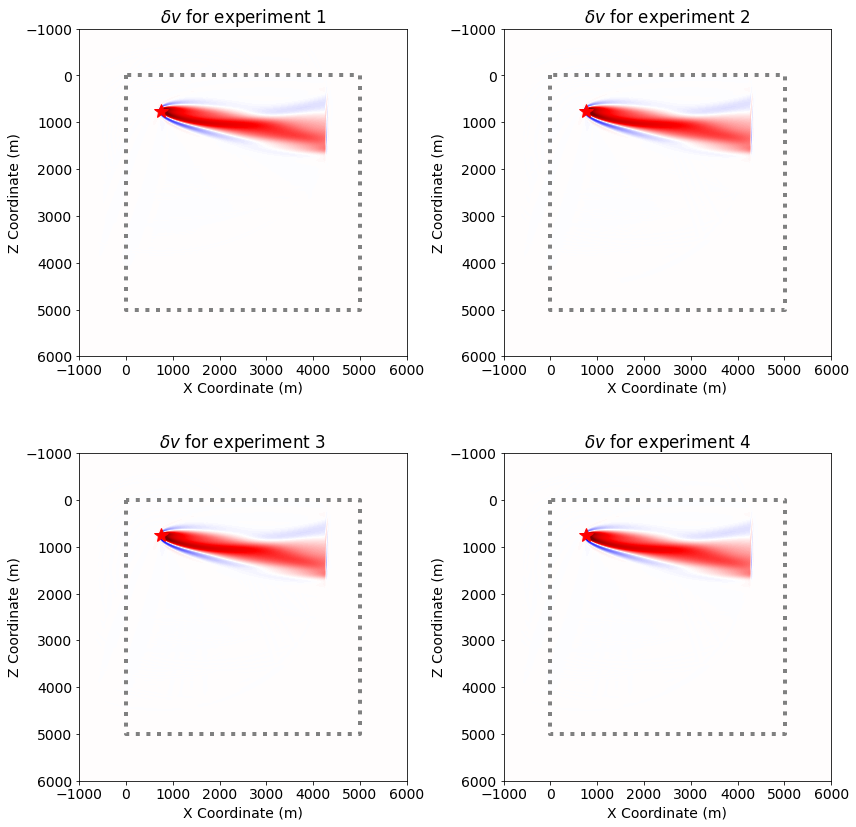

In [129]:
#NBVAL_INGNORE_OUTPUT
vel_max = np.max(np.abs(dvel4.data[:])) / 4.0
plt.figure(figsize=(12,12))

# Background model parameters
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(dvel1.data), cmap="seismic", 
           vmin=-vel_max, vmax=+vel_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 1")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(dvel2.data), cmap="seismic", 
           vmin=-vel_max, vmax=+vel_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 2")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dvel3.data), cmap="seismic", 
           vmin=-vel_max, vmax=+vel_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 3")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(dvel4.data), cmap="seismic", 
           vmin=-vel_max, vmax=+vel_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 4")

plt.tight_layout()
None

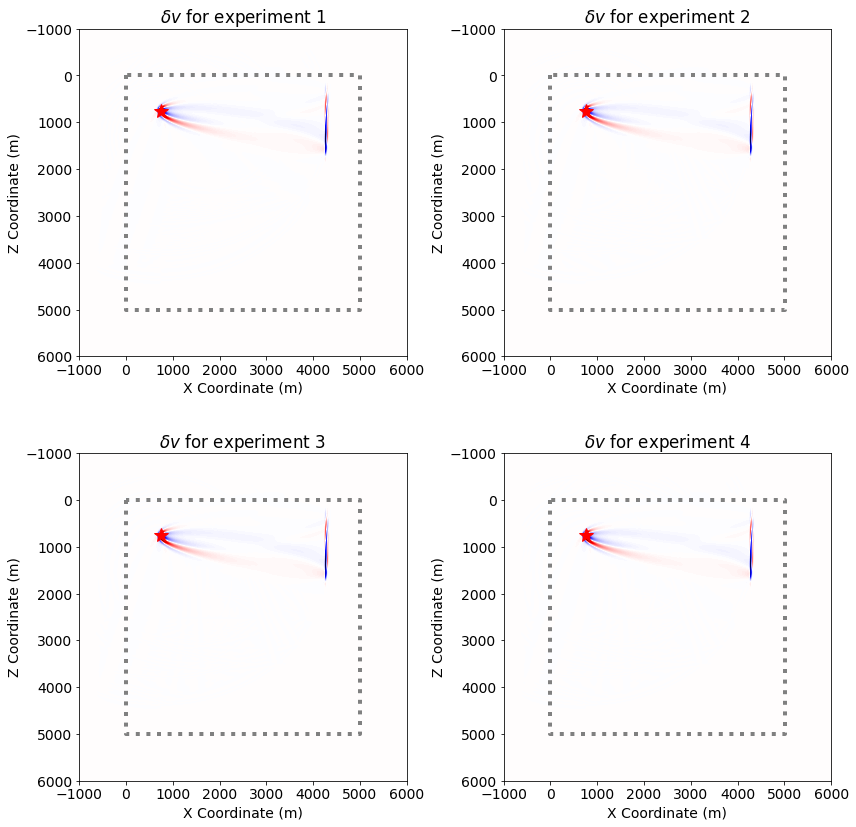

In [131]:
#NBVAL_INGNORE_OUTPUT
eps_max = np.max(np.abs(deps4.data[:])) / 10.0
plt.figure(figsize=(12,12))

# Background model parameters
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(deps1.data), cmap="seismic", 
           vmin=-eps_max, vmax=+eps_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 1")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(deps2.data), cmap="seismic", 
           vmin=-eps_max, vmax=+eps_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 2")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(deps3.data), cmap="seismic", 
           vmin=-eps_max, vmax=+eps_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 3")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(deps4.data), cmap="seismic", 
           vmin=-eps_max, vmax=+eps_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 4")

plt.tight_layout()
None

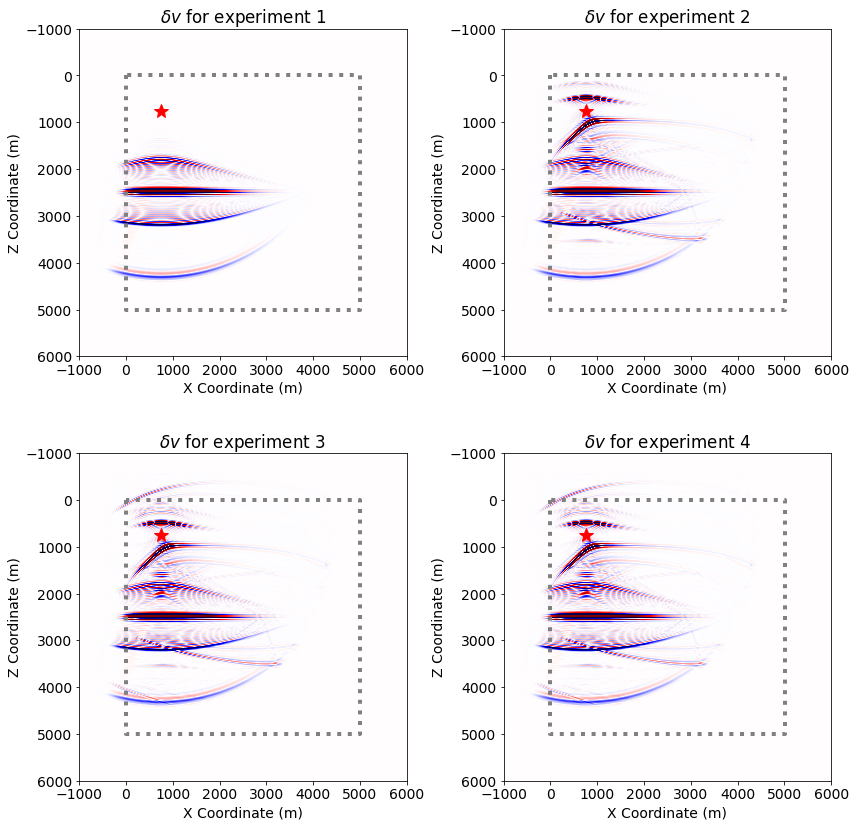

In [132]:
#NBVAL_INGNORE_OUTPUT
eta_max = np.max(np.abs(deta4.data[:])) / 10.0
plt.figure(figsize=(12,12))

# Background model parameters
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(deta1.data), cmap="seismic", 
           vmin=-eta_max, vmax=+eta_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 1")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(deta2.data), cmap="seismic", 
           vmin=-eta_max, vmax=+eta_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 2")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(deta3.data), cmap="seismic", 
           vmin=-eta_max, vmax=+eta_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 3")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(deta4.data), cmap="seismic", 
           vmin=-eta_max, vmax=+eta_max, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("$\delta v$ for experiment 4")

plt.tight_layout()
None

## Discussion

This concludes the implementation of the nonlinear forward operator. This series continues in the next notebook that describes the implementation of the Jacobian linearized forward and adjoint operators.

[ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)


<a id="refs"></a>
## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
